# set up environment

versions that worked:

hssm 0.2.2
pymc 5.14
python 3.11

hssm 0.2.3
pymc newest 

In [1]:
# run on hssm_test
# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import numpy as np
import pandas as pd
import pathlib
import seaborn
from pathlib import Path 
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrix
from ssms.basic_simulators.simulator import simulator
import bambi as bmb
from pandas.api.types import CategoricalDtype
import ssms
import pytensor  # Graph-based tensor library
import hssm
import math
# Set float type to float32 to avoid a current bug in PyMC 
# This will not be necessary in the future
hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


# set up paths

In [2]:
basepath = '/users/afengler/data/proj_tt/mpib-HSSM-oddball-data'

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/models/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/results/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/plots/hssm/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/ppc/hssm/').mkdir(parents=True, exist_ok=True)

# set up data

In [3]:
df = pd.read_csv(basepath+'/data/OB_singletrial_YAOA.csv')

df['response'] = df['accuracy']
# And then modify the 'response' column where the condition is met
df.loc[df['response'] == 0, 'response'] = -1

df.rename(columns={'reactiontime': 'rt'}, inplace=True)
df.rename(columns={'id': 'participant_id'}, inplace=True)

oddballDataDay2 = df[df['response'].notna()]

data=oddballDataDay2[:]
dataForModel = data[data['pupil'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['beta_insula'].notna()]

dataForModel = dataForModel.copy()
dataForModel = dataForModel[dataForModel['switch_condition_num'].notna()]


dataForModel['switch_condition_num']=isinstance(dataForModel['switch_condition_num'].dtype, CategoricalDtype)

### first look at real data RT

In [4]:
oddballDataDay2.rt.min()

0.0201793451615231

/tmp/ipykernel_936972/3106038759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oddballDataDay2['rtPlot']=oddballDataDay2['rt']


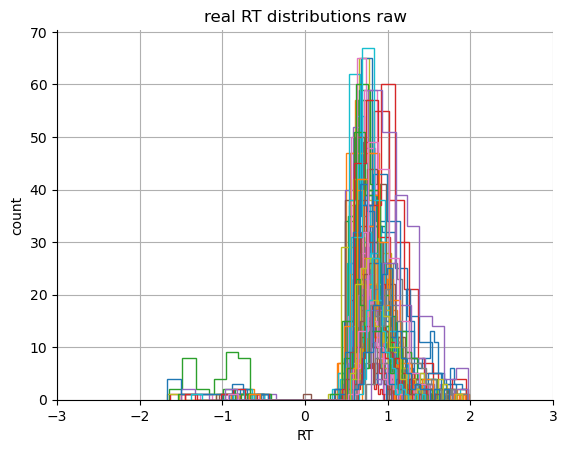

In [4]:
oddballDataDay2['rtPlot']=oddballDataDay2['rt']
oddballDataDay2.loc[oddballDataDay2['response'] == -1,'rtPlot']=oddballDataDay2.loc[oddballDataDay2['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw')
for i, subj_data in oddballDataDay2.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/figures/real_subRT_dist.pdf')

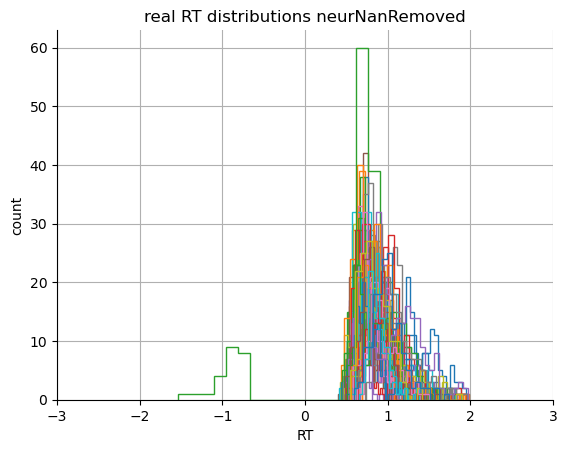

In [5]:
dataForModel['rtPlot']=dataForModel['rt']
dataForModel.loc[dataForModel['response'] == -1,'rtPlot']=dataForModel.loc[dataForModel['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions neurNanRemoved')
for i, subj_data in dataForModel.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/figures/real_subRT_dist_neurNanRemoved.pdf')

### day2SubList

In [5]:
# based on the real data, we figure:
# we need to simulate data with 'participant_id','rt',and 'response' 
# we need to get the correct sub numbers out and also correct trial number (samples in simulation) per subject
day2SubList=oddballDataDay2['participant_id'].unique()
len(day2SubList)


71

# set up sampler for real data

In [5]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=oddballDataDay2,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [7]:
ddm_simple_allFree_hier._initvals


{'v_Intercept': array(0., dtype=float32),
 'v_1|participant_id_sigma': array(0.2708236, dtype=float32),
 'v_1|participant_id': array([-7.6181879e-03, -9.6288917e-04,  4.9474364e-04,  8.9970399e-03,
        -4.5653214e-03,  2.6056988e-03, -9.1532692e-03, -2.1170431e-03,
         8.4916539e-03, -1.7512753e-03,  1.6235801e-03,  9.2402920e-03,
         1.7212994e-03, -8.5418336e-03, -7.5415578e-03, -5.6232288e-03,
         2.2886074e-03,  6.6763479e-03,  3.6369970e-03, -3.4151440e-03,
        -4.1940733e-04, -9.4269281e-03, -2.1147372e-03, -8.6767022e-03,
         5.0138151e-03, -9.8811332e-03, -7.3427046e-03, -8.9206593e-03,
         9.5783444e-03, -1.0223742e-04,  1.0129651e-03,  9.0419938e-04,
        -9.9026514e-03, -5.6823315e-03, -4.4843674e-04,  2.0939831e-03,
         3.4465592e-03,  7.1340688e-03, -8.9192605e-03,  7.3926584e-03,
         3.3749915e-03, -1.9553076e-03, -6.4887316e-03,  5.4030605e-03,
         3.8617768e-03,  7.5358883e-03,  5.9242668e-03, -2.8348045e-04,
        -6

In [6]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=3000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



2024-09-02 09:58:56.866016: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

In [31]:
pathlib.Path(basepath+'/models/ddm/sept24/numpyro/').mkdir(parents=True, exist_ok=True)


fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_hier.nc'
data = inferenceData_ddm_simple_allFree_hier
az.to_netcdf(data, fileName)

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_hier.nc'

In [5]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_hier.nc'
ddm_inferenceData=az.from_netcdf(fileName)
ddm_inferenceData

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
az.summary(ddm_inferenceData,var_names=['v0_Intercept',
                                                'v1_Intercept',
                                                'v2_Intercept',
                                                'a_Intercept',
                                                'z_Intercept',
                                                't_Intercept'])

/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or n

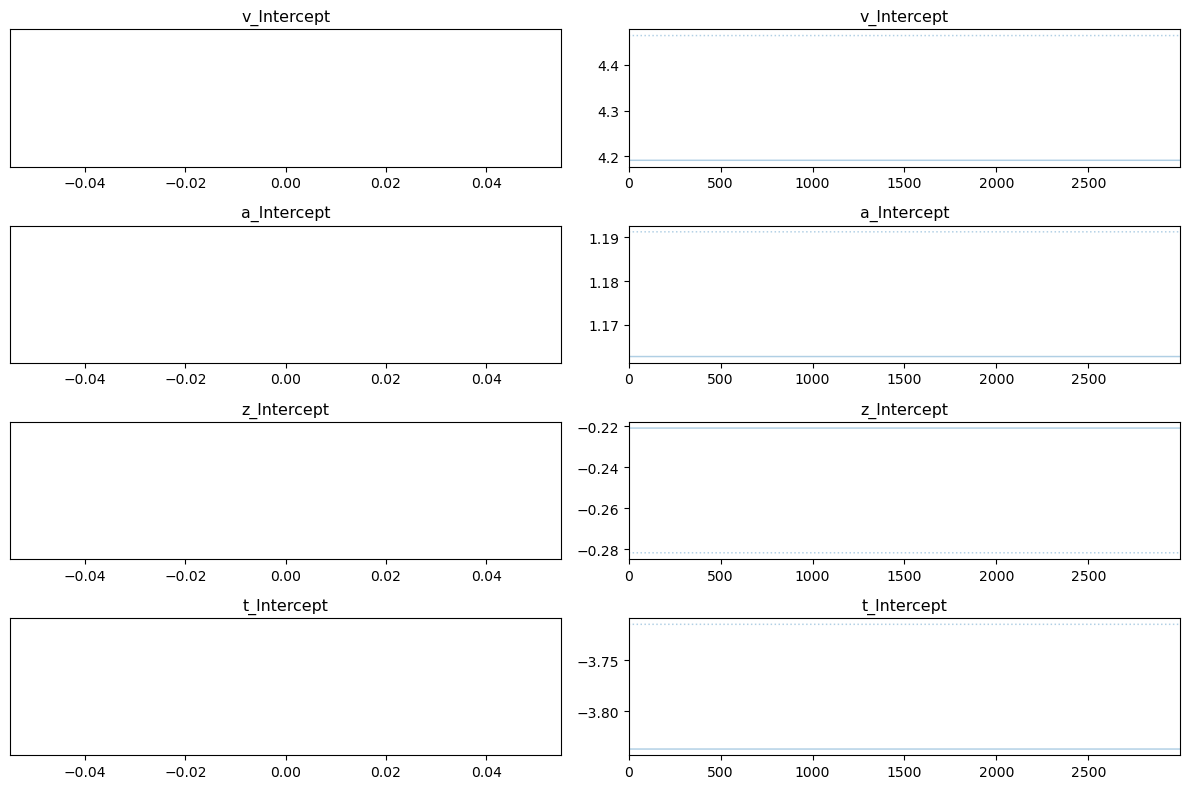

In [7]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

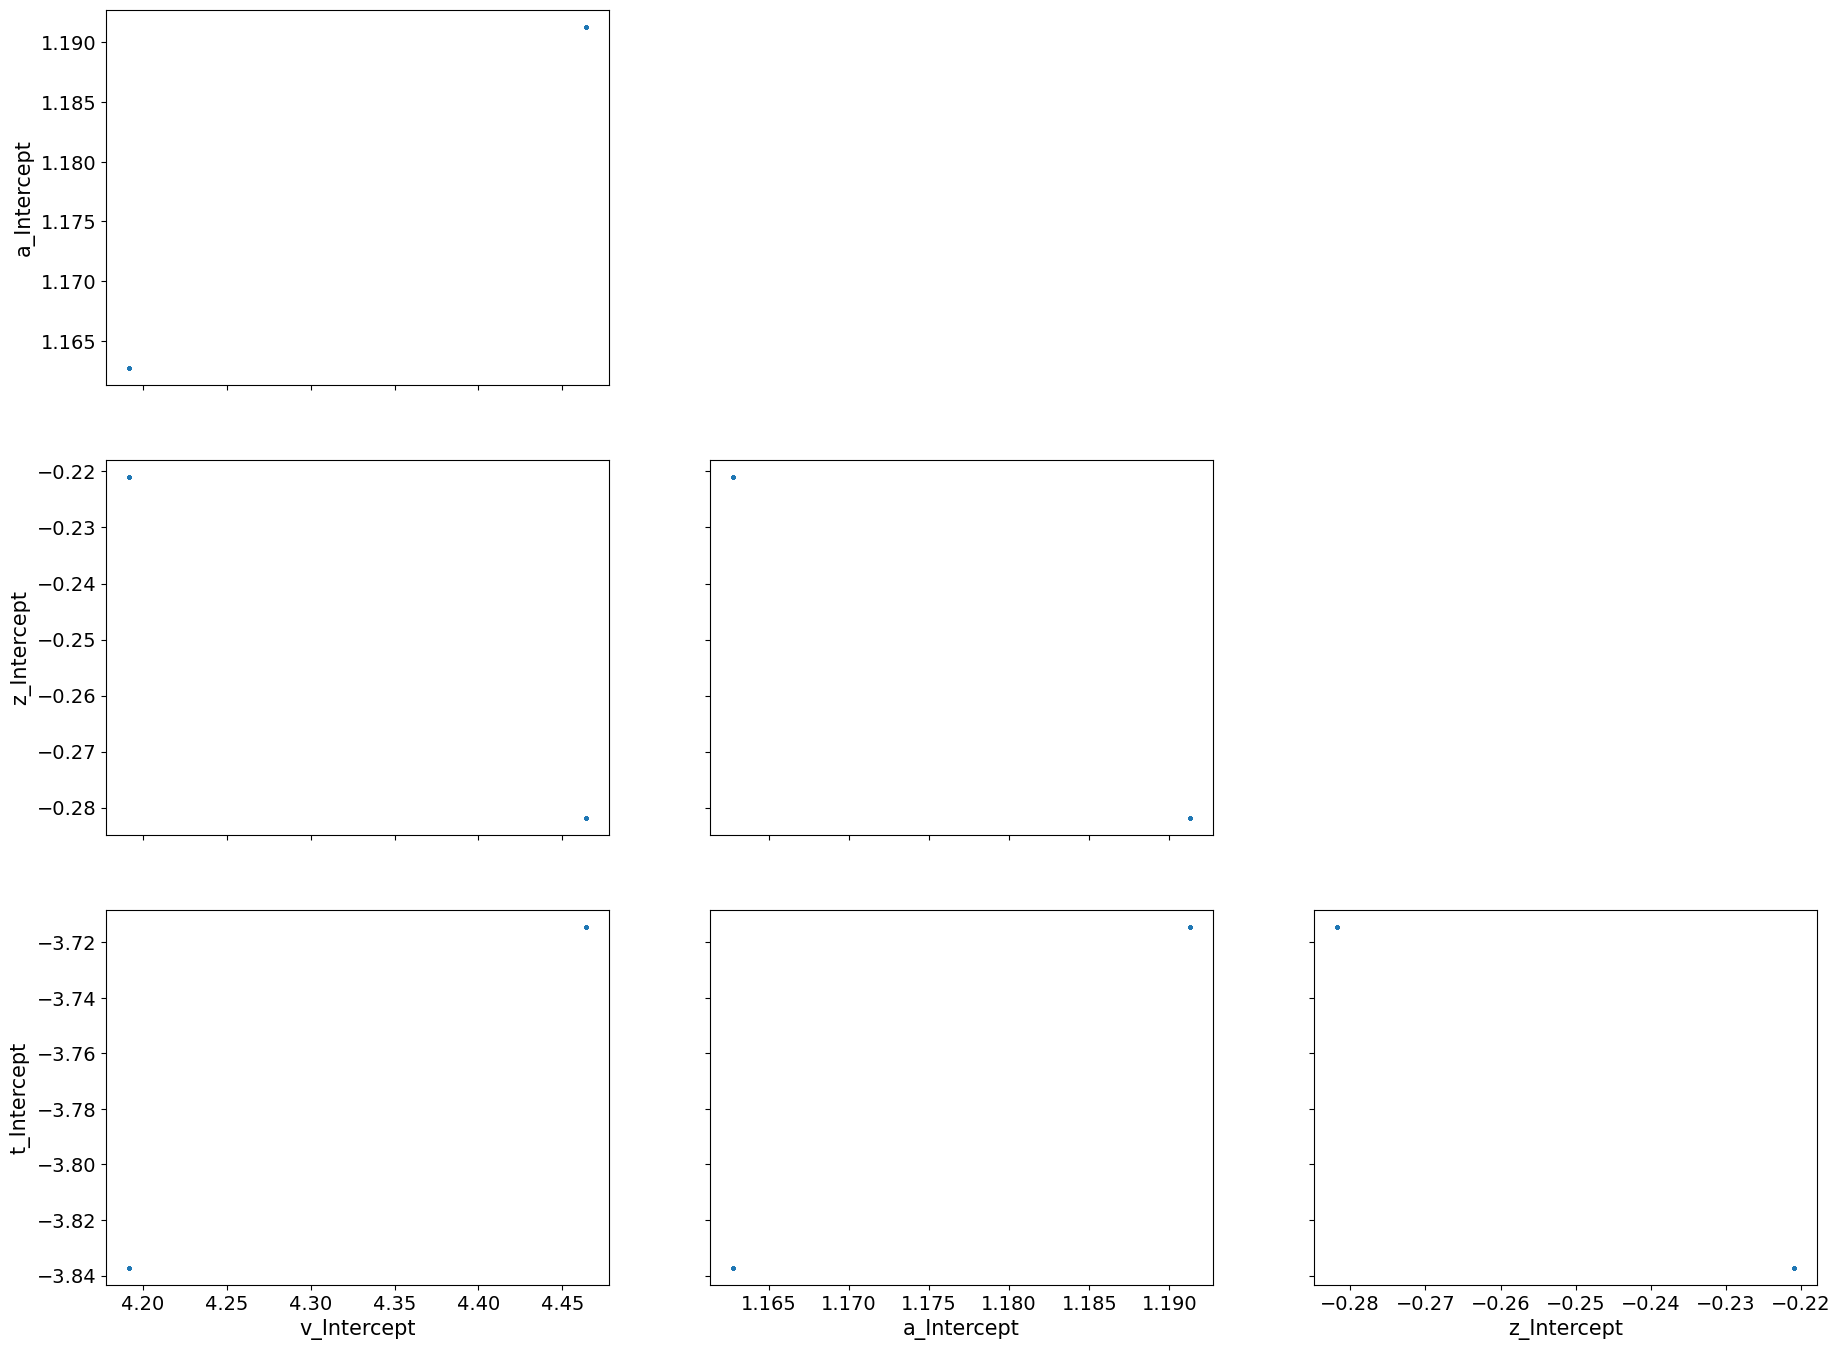

In [8]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

# simulate data: simplest DDM all params free

## nuts numpyro

In [8]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x7f90a0f72260>}

In [82]:
vanillaHDDMallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(2,0.05), 
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simData=pd.concat([vanillaHDDMallFree_simData, subDataset], ignore_index=True)

In [83]:
vanillaHDDMallFree_simData

participant_id        rt  response
0             42013.0  0.539640       1.0
1             42013.0  0.744280       1.0
2             42013.0  0.505983       1.0
3             42013.0  1.406529       1.0
4             42013.0  0.910031       1.0
...               ...       ...       ...
11222         62433.0  0.927285       1.0
11223         62433.0  0.593821       1.0
11224         62433.0  0.482578       1.0
11225         62433.0  0.547123       1.0
11226         62433.0  0.521996       1.0

[11227 rows x 3 columns]

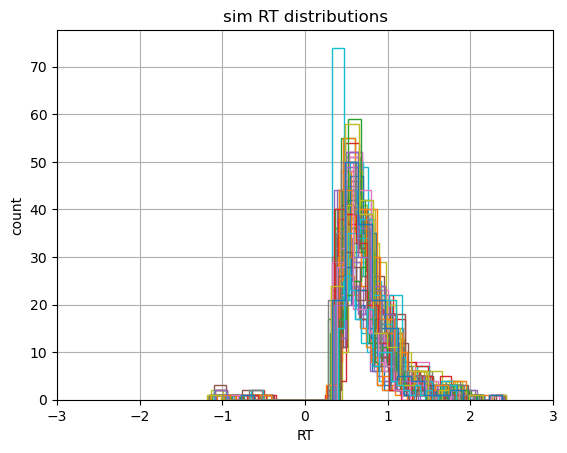

In [84]:
vanillaHDDMallFree_simData['rtPlot']=vanillaHDDMallFree_simData['rt']
vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']=vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions')
for i, subj_data in vanillaHDDMallFree_simData.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist.pdf')

In [85]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=vanillaHDDMallFree_simData,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [81]:
ddm_simple_allFree_hier

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 11084

Parameters:

v:
    Formula: v ~ 1 + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + (1|participant_id)
    Priors:
        a_Intercept ~ Gamma(mu: 1.5, sigma: 0.75)
        a_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|participant_id)
    Priors:
        z_Intercept ~ Beta(alpha: 10.0, beta: 10.0)
        z_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ 1 + (1|participant_id)
    Priors:
        t_Intercept ~ Gamma(mu: 

In [86]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

In [87]:
inferenceData_ddm_simple_allFree_hier

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

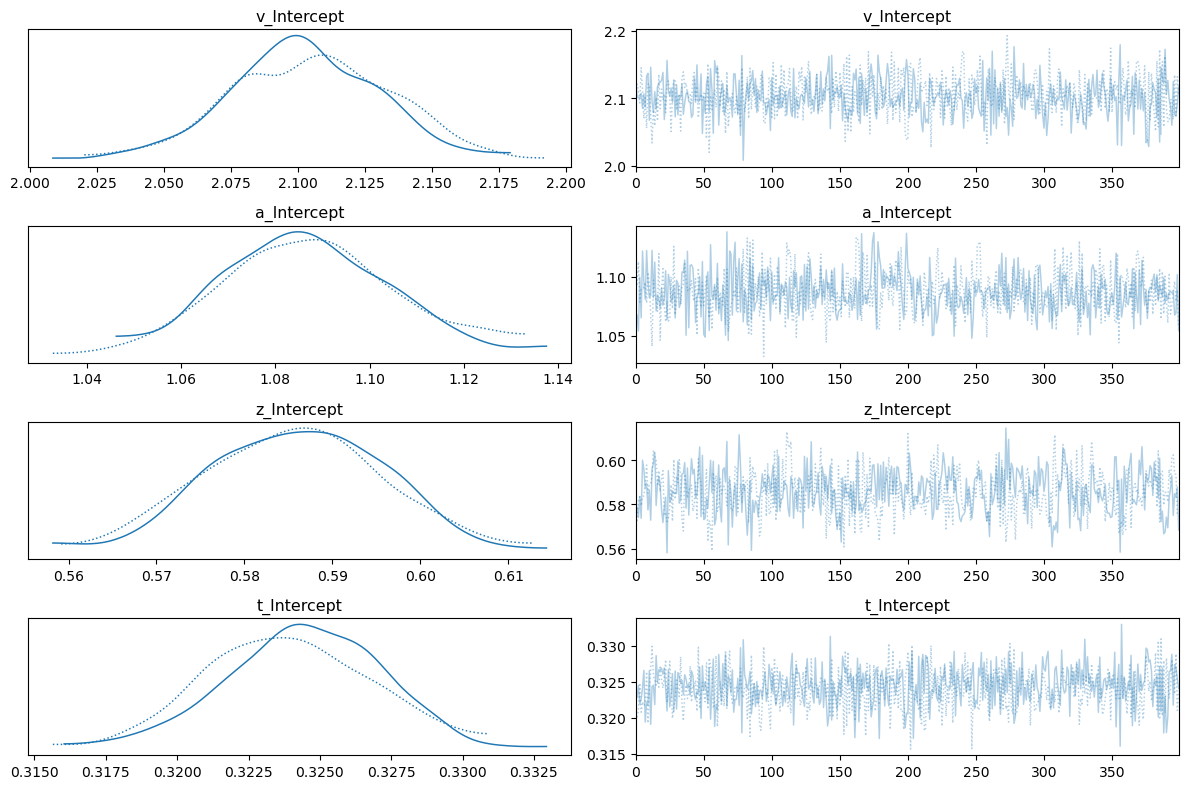

In [88]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

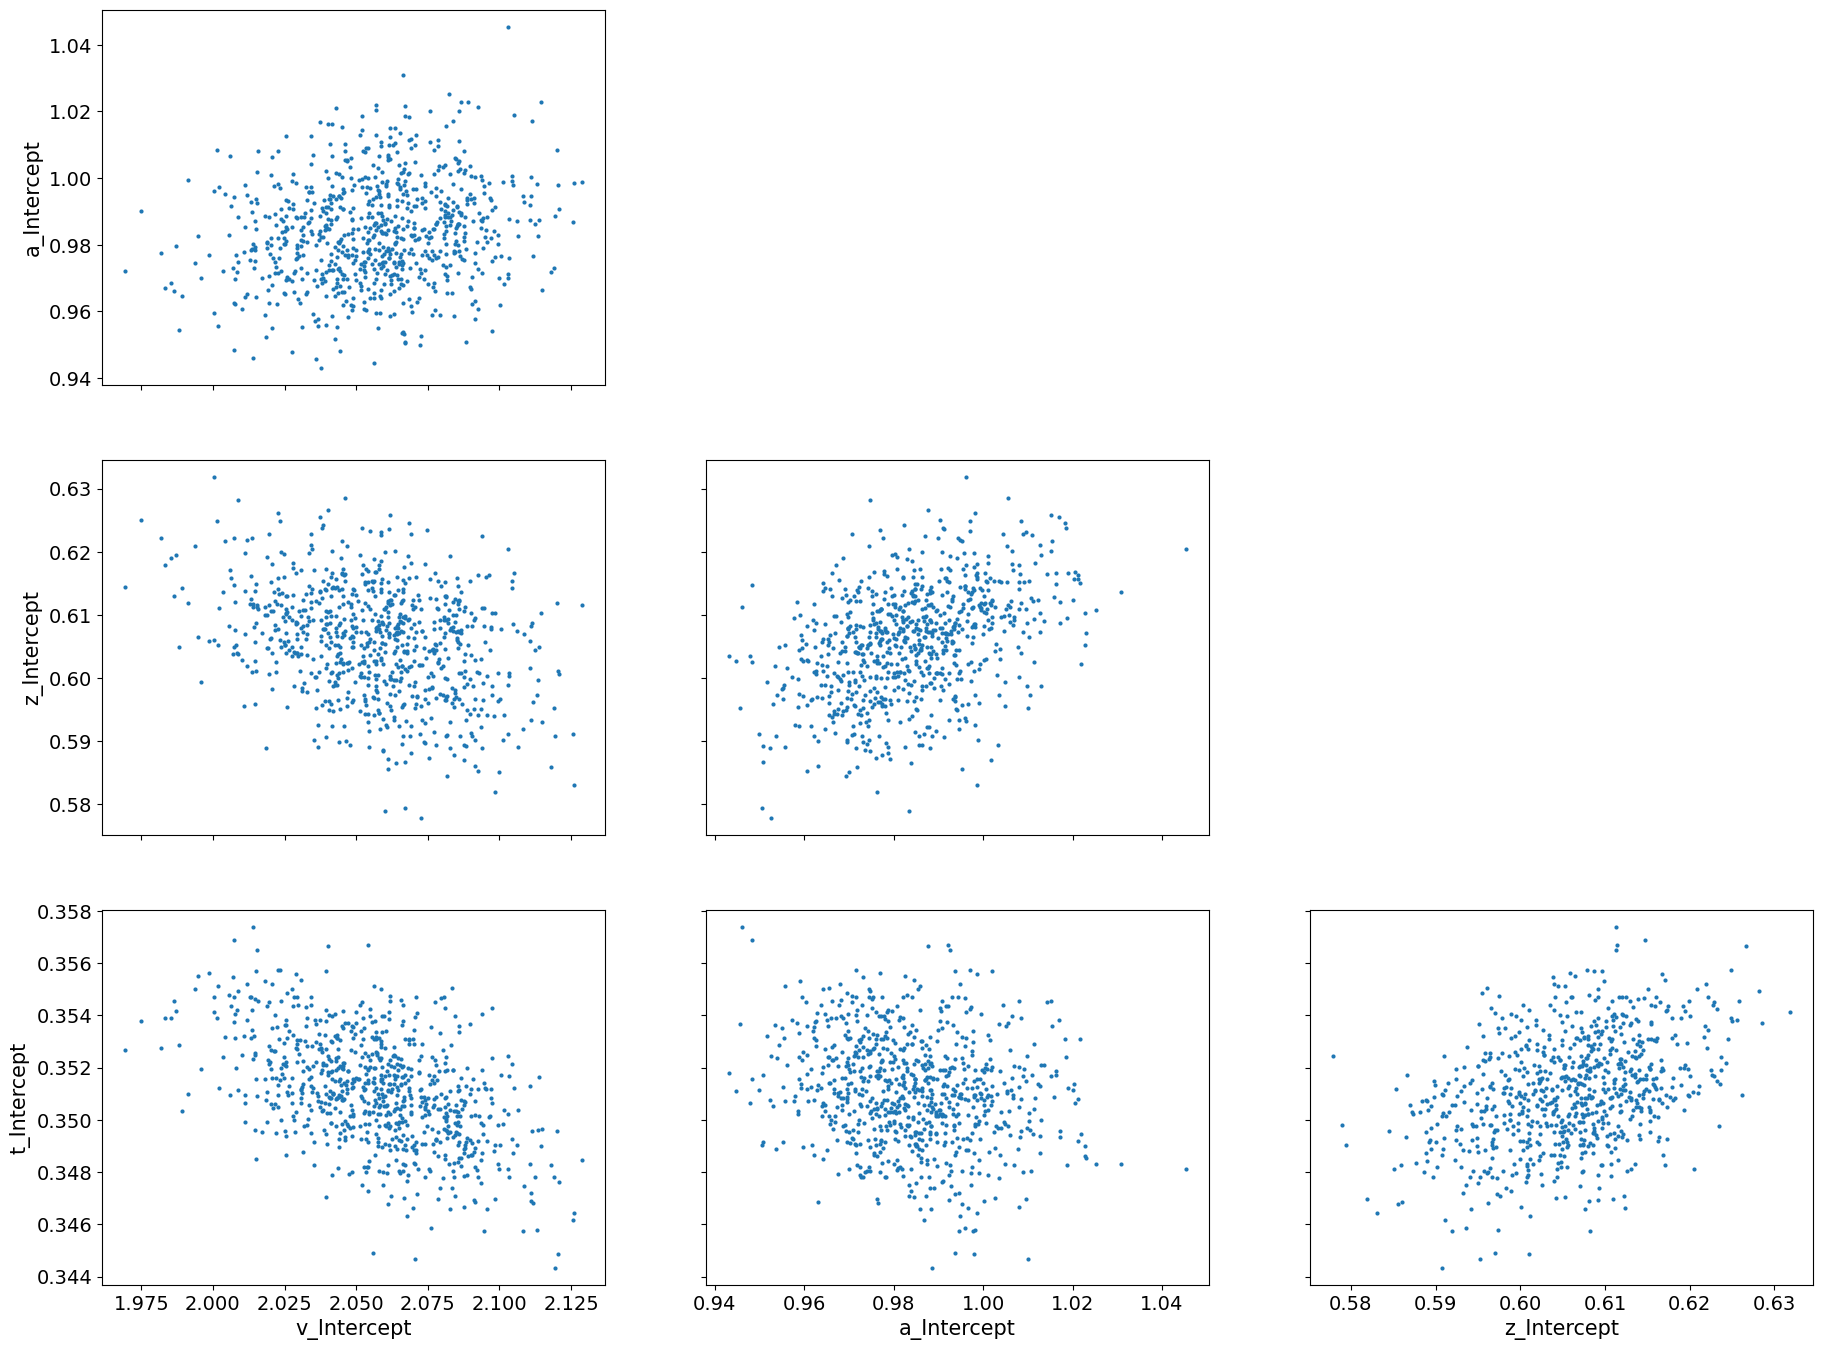

In [78]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

### play around with the ground truth params to simulate data with more errors

In [64]:
vanillaHDDMallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(dataForModel.loc[dataForModel['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(0.1,0.005), #play with v, closer to zero will lead to more even upper and lower bound choices
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simDataEvenChoice=pd.concat([vanillaHDDMallFree_simDataEvenChoice, subDataset], ignore_index=True)
    
vanillaHDDMallFree_simDataEvenChoice    

participant_id        rt  response
0             42013.0  2.414007       1.0
1             42013.0  1.059152       1.0
2             42013.0  1.028316      -1.0
3             42013.0  1.948087       1.0
4             42013.0  1.812551      -1.0
...               ...       ...       ...
11079         62433.0  0.598226       1.0
11080         62433.0  1.437814       1.0
11081         62433.0  1.256375      -1.0
11082         62433.0  0.573281       1.0
11083         62433.0  2.346781       1.0

[11084 rows x 3 columns]

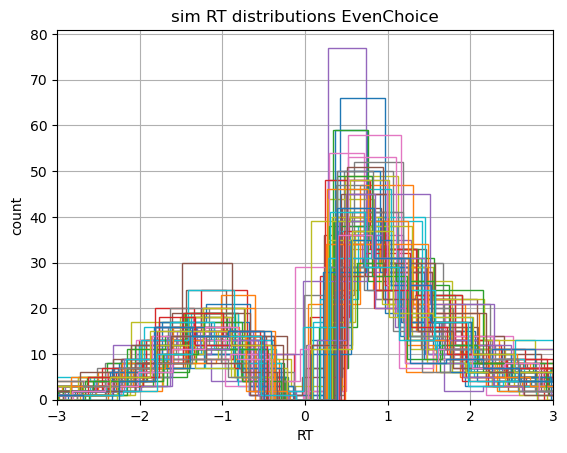

In [66]:
vanillaHDDMallFree_simDataEvenChoice['rtPlot']=vanillaHDDMallFree_simDataEvenChoice['rt']
vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']=vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions EvenChoice')
for i, subj_data in vanillaHDDMallFree_simDataEvenChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

plt.xlim(-3,3)   
plt.savefig('sim_subRT_dist_even.pdf')

In [72]:
ddm_simple_allFree_hier_even = hssm.HSSM(
    data=vanillaHDDMallFree_simDataEvenChoice,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [73]:
inferenceData_ddm_simple_allFree_hier_even=ddm_simple_allFree_hier_even.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=400,
    tune=400,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

In [75]:
inferenceData_ddm_simple_allFree_hier_even

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

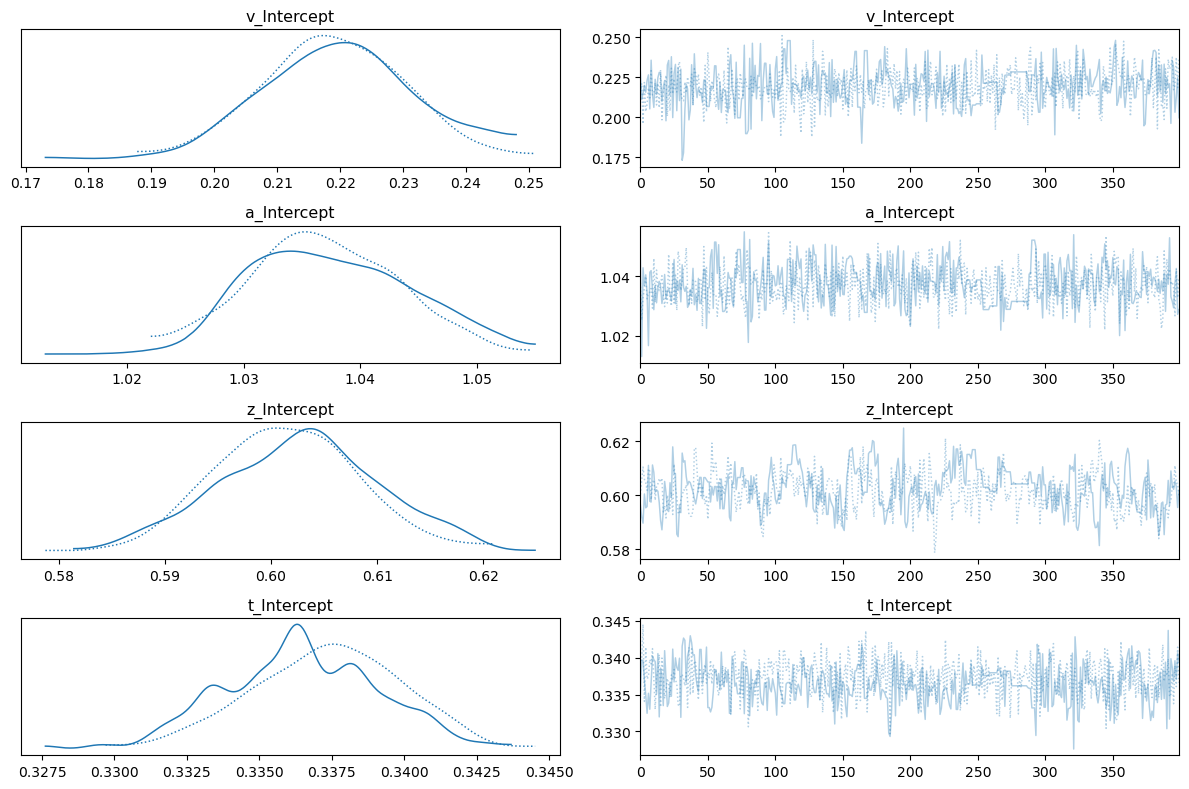

In [76]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

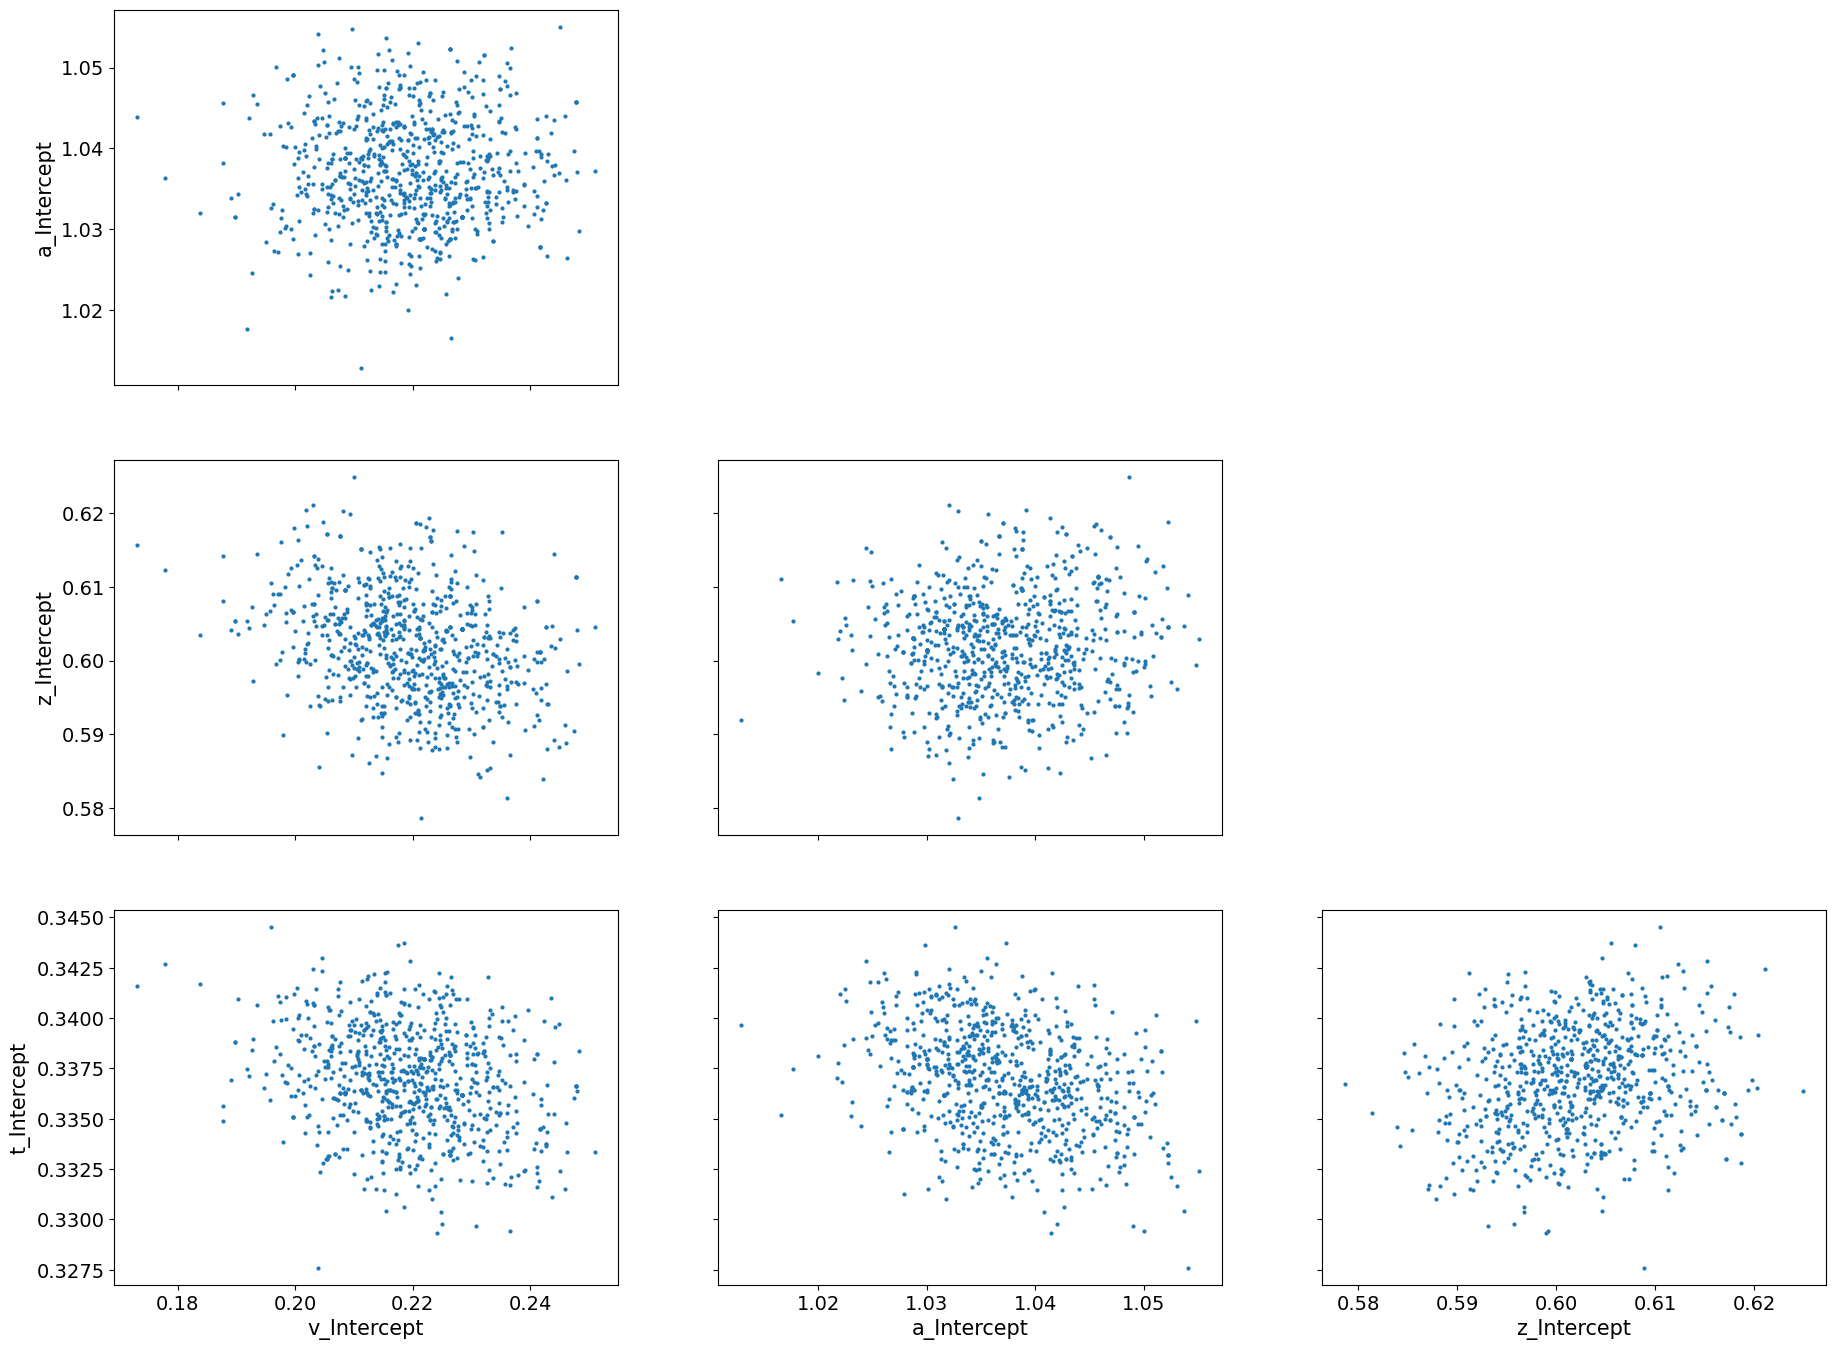

In [79]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

## nuts numpyro with ground truth from real data instead 

In [ ]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary_name': 'constant',
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'boundary_params': [],
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'nchoices': 2,
 'simulator': <cyfunction ddm_flexbound at 0x7f90a0f72260>}

In [25]:
vanillaHDDMallFree_simData=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(2.021,0.005), 
                                      np.random.normal(1.405,0.068), 
                                      np.random.normal(0.573,0.056),
                                      np.random.normal(0.372,0.029)]


    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simData=pd.concat([vanillaHDDMallFree_simData, subDataset], ignore_index=True)

In [ ]:
vanillaHDDMallFree_simData

participant_id        rt  response
0             42013.0  0.392496       1.0
1             42013.0  0.439485       1.0
2             42013.0  0.707260       1.0
3             42013.0  0.626655       1.0
4             42013.0  0.573257       1.0
...               ...       ...       ...
11079         62433.0  1.079464       1.0
11080         62433.0  0.844995       1.0
11081         62433.0  0.418700       1.0
11082         62433.0  0.431456       1.0
11083         62433.0  0.945176       1.0

[11084 rows x 3 columns]

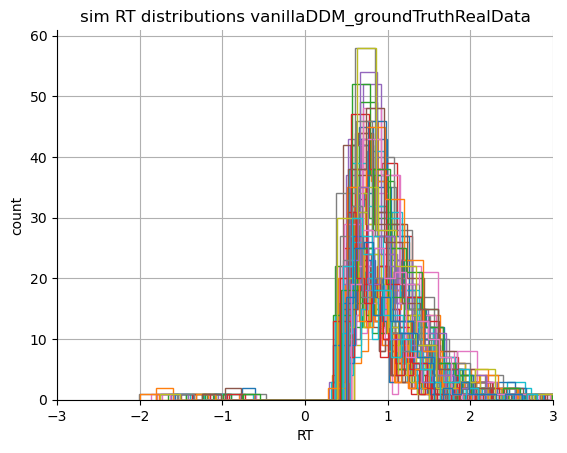

In [27]:
vanillaHDDMallFree_simData['rtPlot']=vanillaHDDMallFree_simData['rt']
vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']=vanillaHDDMallFree_simData.loc[vanillaHDDMallFree_simData['response'] == -1,'rtPlot']*-1
fig = plt.figure()

ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions vanillaDDM_groundTruthRealData')
for i, subj_data in vanillaHDDMallFree_simData.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/figures/sim_subRT_dist_vanillaDDM_groundTruthRealData.pdf')

In [10]:
ddm_simple_allFree_hier = hssm.HSSM(
    data=vanillaHDDMallFree_simData,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [11]:
inferenceData_ddm_simple_allFree_hier=ddm_simple_allFree_hier.sample(
    sampler="nuts_numpyro",
    chains=4,
    draws=3000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



2024-09-01 16:59:56.993206: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

In [14]:
pathlib.Path(basepath+'/models/ddm/sept24/numpyro/').mkdir(parents=True, exist_ok=True)


fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_sim_ddm_simple_allFree_hier.nc'
data = inferenceData_ddm_simple_allFree_hier
az.to_netcdf(data, fileName)

'/users/afengler/data/proj_tt/mpib-HSSM-oddball-data/models/ddm/sept24/numpyro/inferenceData_sim_ddm_simple_allFree_hier.nc'

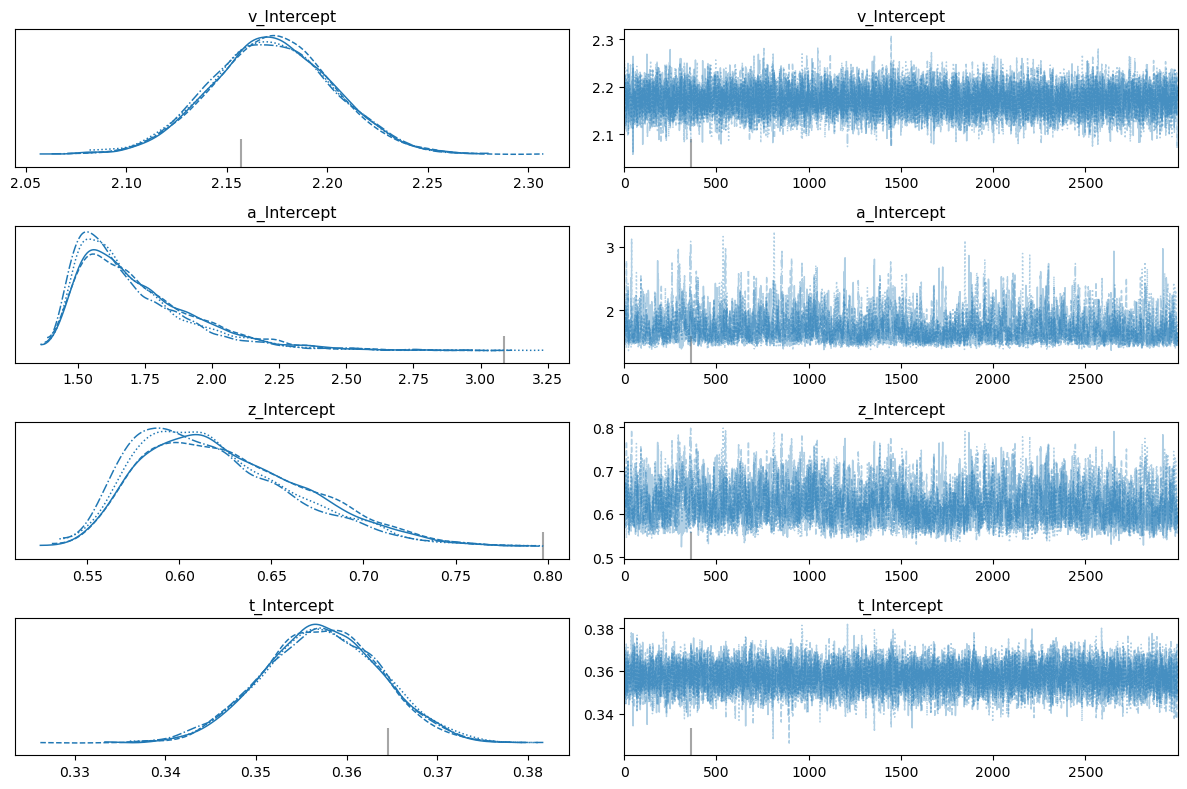

In [15]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

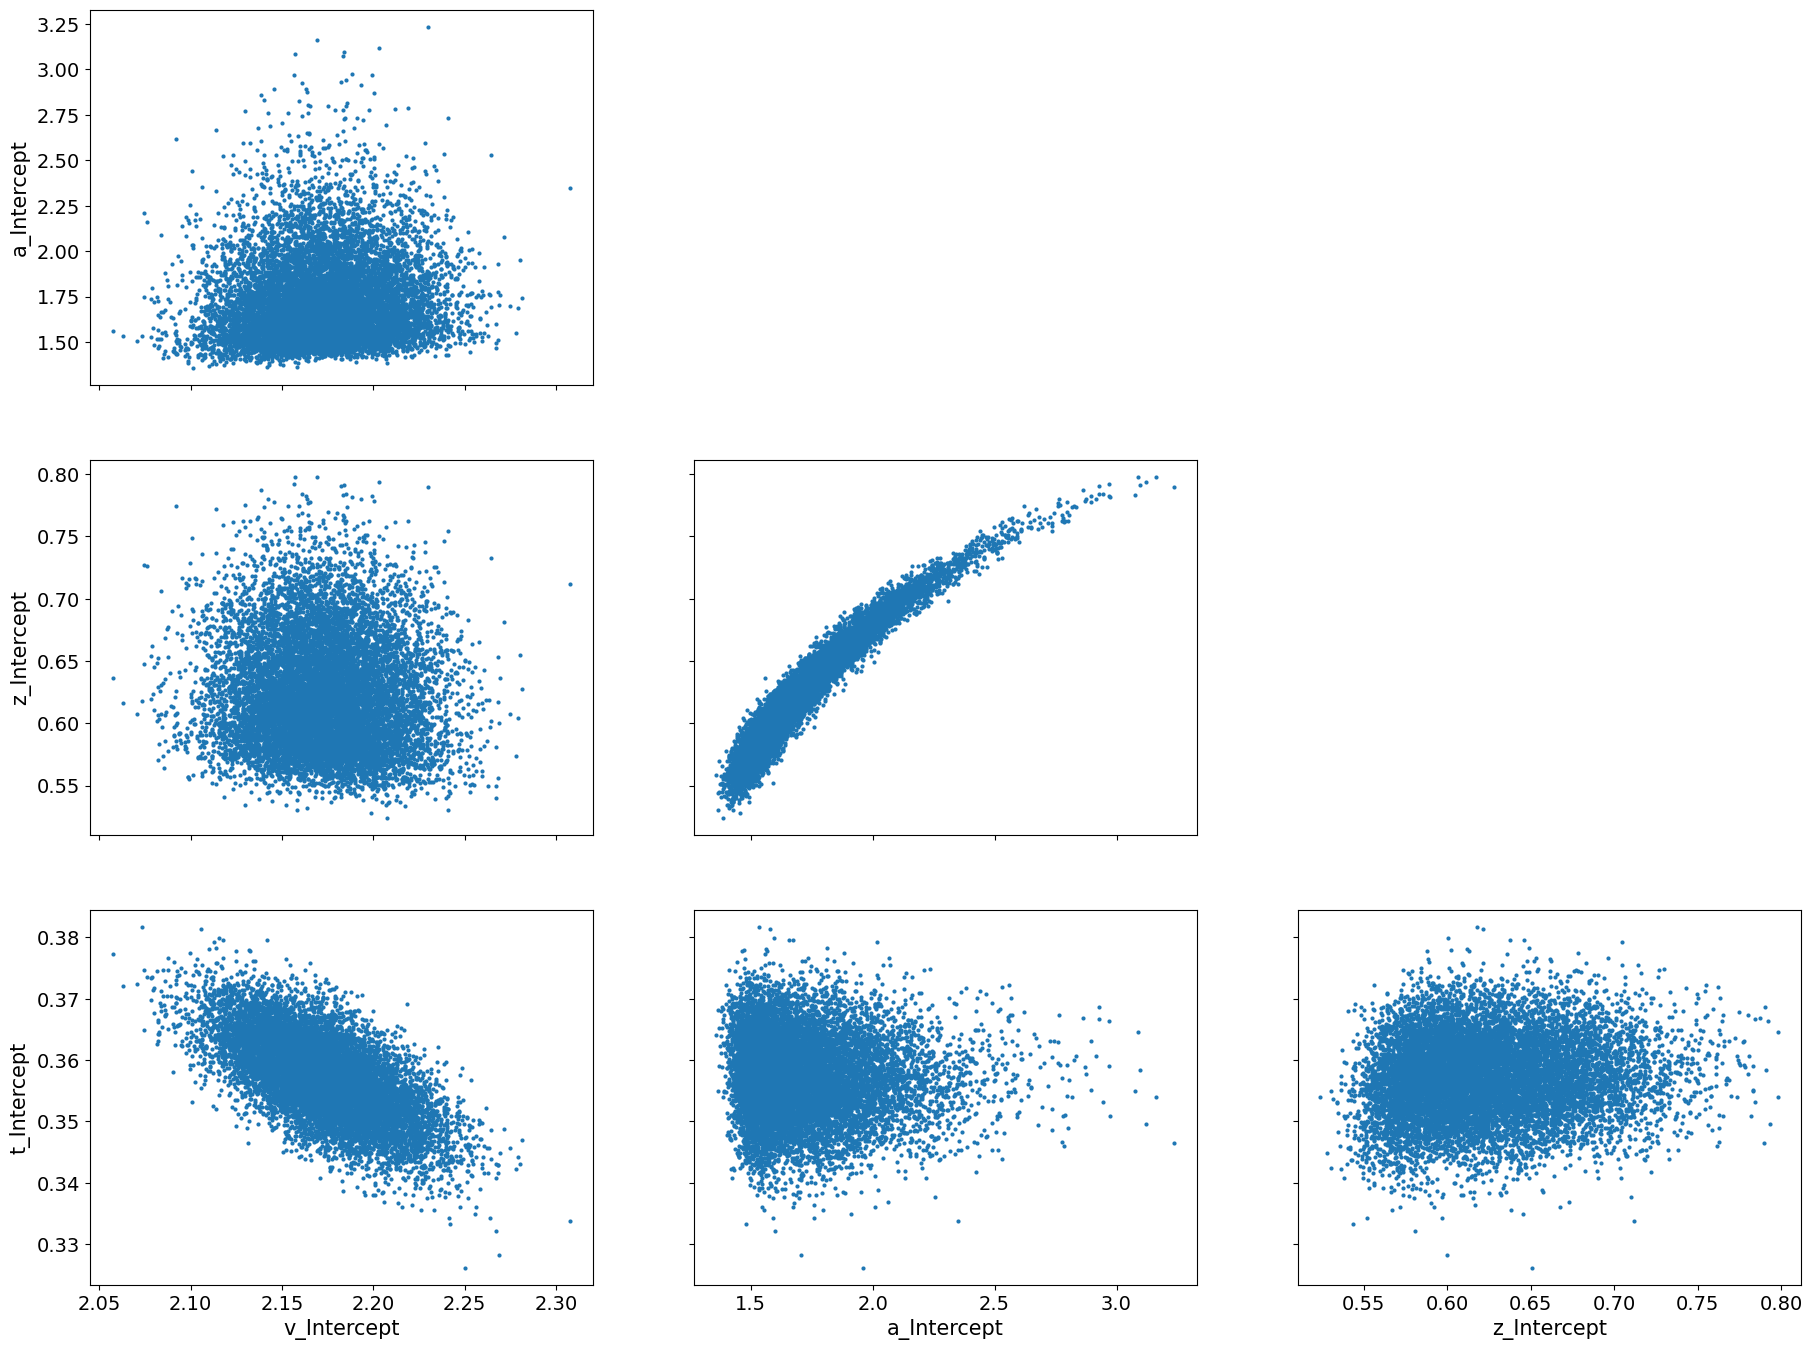

In [28]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

### play around with the ground truth params to simulate data with more errors

In [5]:
vanillaHDDMallFree_simDataEvenChoice=pd.DataFrame();
for sub in range(len(day2SubList)):
    
    idNum=day2SubList[sub]
    
    # figure out trial number from real data for the sub to determine sample numbers in the simulator
    trialNum=len(oddballDataDay2.loc[oddballDataDay2['participant_id'] == idNum])
    
    idCol=pd.DataFrame({'participant_id': [idNum] * trialNum})

    # Specify parameters based on gaussians using stats from the model fit with real data
    v_true, a_true, z_true, t_true = [np.random.normal(0.1,0.005), #play with v, closer to zero will lead to more even upper and lower bound choices
                                      np.random.normal(1,0.05), 
                                      np.random.normal(0.6,0.05),
                                      np.random.normal(0.35,0.01)]

    # Simulate data
    sim_out = simulator(
        theta=[v_true, a_true, z_true, t_true],  # parameter list
        model="ddm",  # specify model (many are included in ssms)
        n_samples=trialNum,  # number of samples for each set of parameters
    )

    # Turn into nice dataset
    # Turn data into a pandas dataframe
    subDataset = pd.DataFrame(
        np.column_stack([idCol["participant_id"],sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
        columns=["participant_id", "rt", "response"],
    )

    vanillaHDDMallFree_simDataEvenChoice=pd.concat([vanillaHDDMallFree_simDataEvenChoice, subDataset], ignore_index=True)
    
vanillaHDDMallFree_simDataEvenChoice    

participant_id        rt  response
0             42013.0  0.537685      -1.0
1             42013.0  1.274130      -1.0
2             42013.0  0.816495       1.0
3             42013.0  0.467439       1.0
4             42013.0  0.627679       1.0
...               ...       ...       ...
11222         62433.0  0.626851      -1.0
11223         62433.0  1.089380      -1.0
11224         62433.0  0.971346       1.0
11225         62433.0  0.369588       1.0
11226         62433.0  1.991250       1.0

[11227 rows x 3 columns]

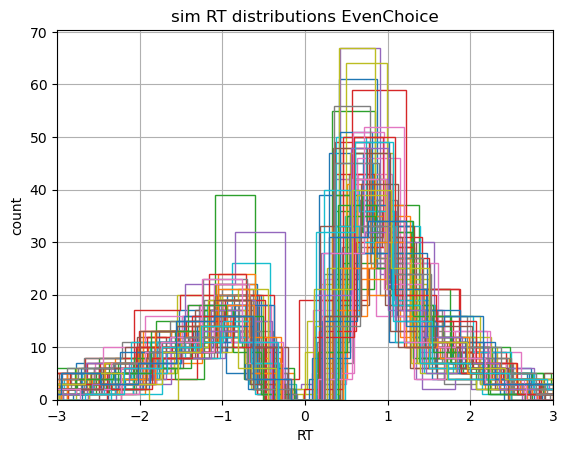

In [6]:
vanillaHDDMallFree_simDataEvenChoice['rtPlot']=vanillaHDDMallFree_simDataEvenChoice['rt']
vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']=vanillaHDDMallFree_simDataEvenChoice.loc[vanillaHDDMallFree_simDataEvenChoice['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='sim RT distributions EvenChoice')
for i, subj_data in vanillaHDDMallFree_simDataEvenChoice.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/figures/sim_subRT_dist_vanillaDDM_groundTruthRealDataEvenChoice.pdf')

In [7]:
ddm_simple_allFree_hier_even = hssm.HSSM(
    data=vanillaHDDMallFree_simDataEvenChoice,
    model="ddm",
    hierarchical=True,
    noncentered=False,
    # link_settings="log_logit",
    # prior_settings="safe",   
)

Model initialized successfully.


In [8]:
inferenceData_ddm_simple_allFree_hier_even=ddm_simple_allFree_hier_even.sample(
    sampler="nuts_numpyro",
    chains=4,
    draws=3000,
    tune=1000,
    idata_kwargs=dict(log_likelihood=True),
    )

Using default initvals. 



2024-09-01 19:46:40.073913: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods

KeyboardInterrupt: 

In [ ]:
pathlib.Path(basepath+'/models/ddm/sept24/numpyro/').mkdir(parents=True, exist_ok=True)


fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_sim_evenChoice_ddm_simple_allFree_hier.nc'
data = inferenceData_ddm_simple_allFree_hier
az.to_netcdf(data, fileName)

In [ ]:
inferenceData_ddm_simple_allFree_hier_even

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

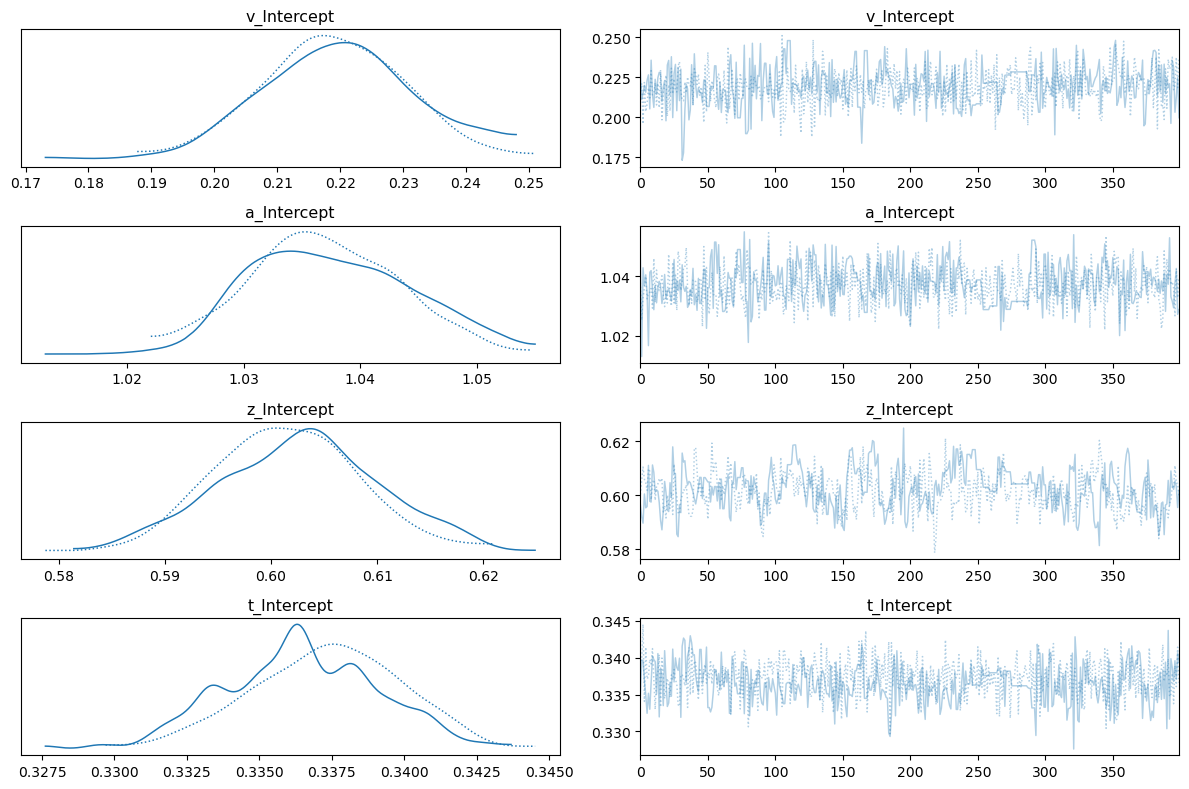

In [ ]:
az.plot_trace(
    inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

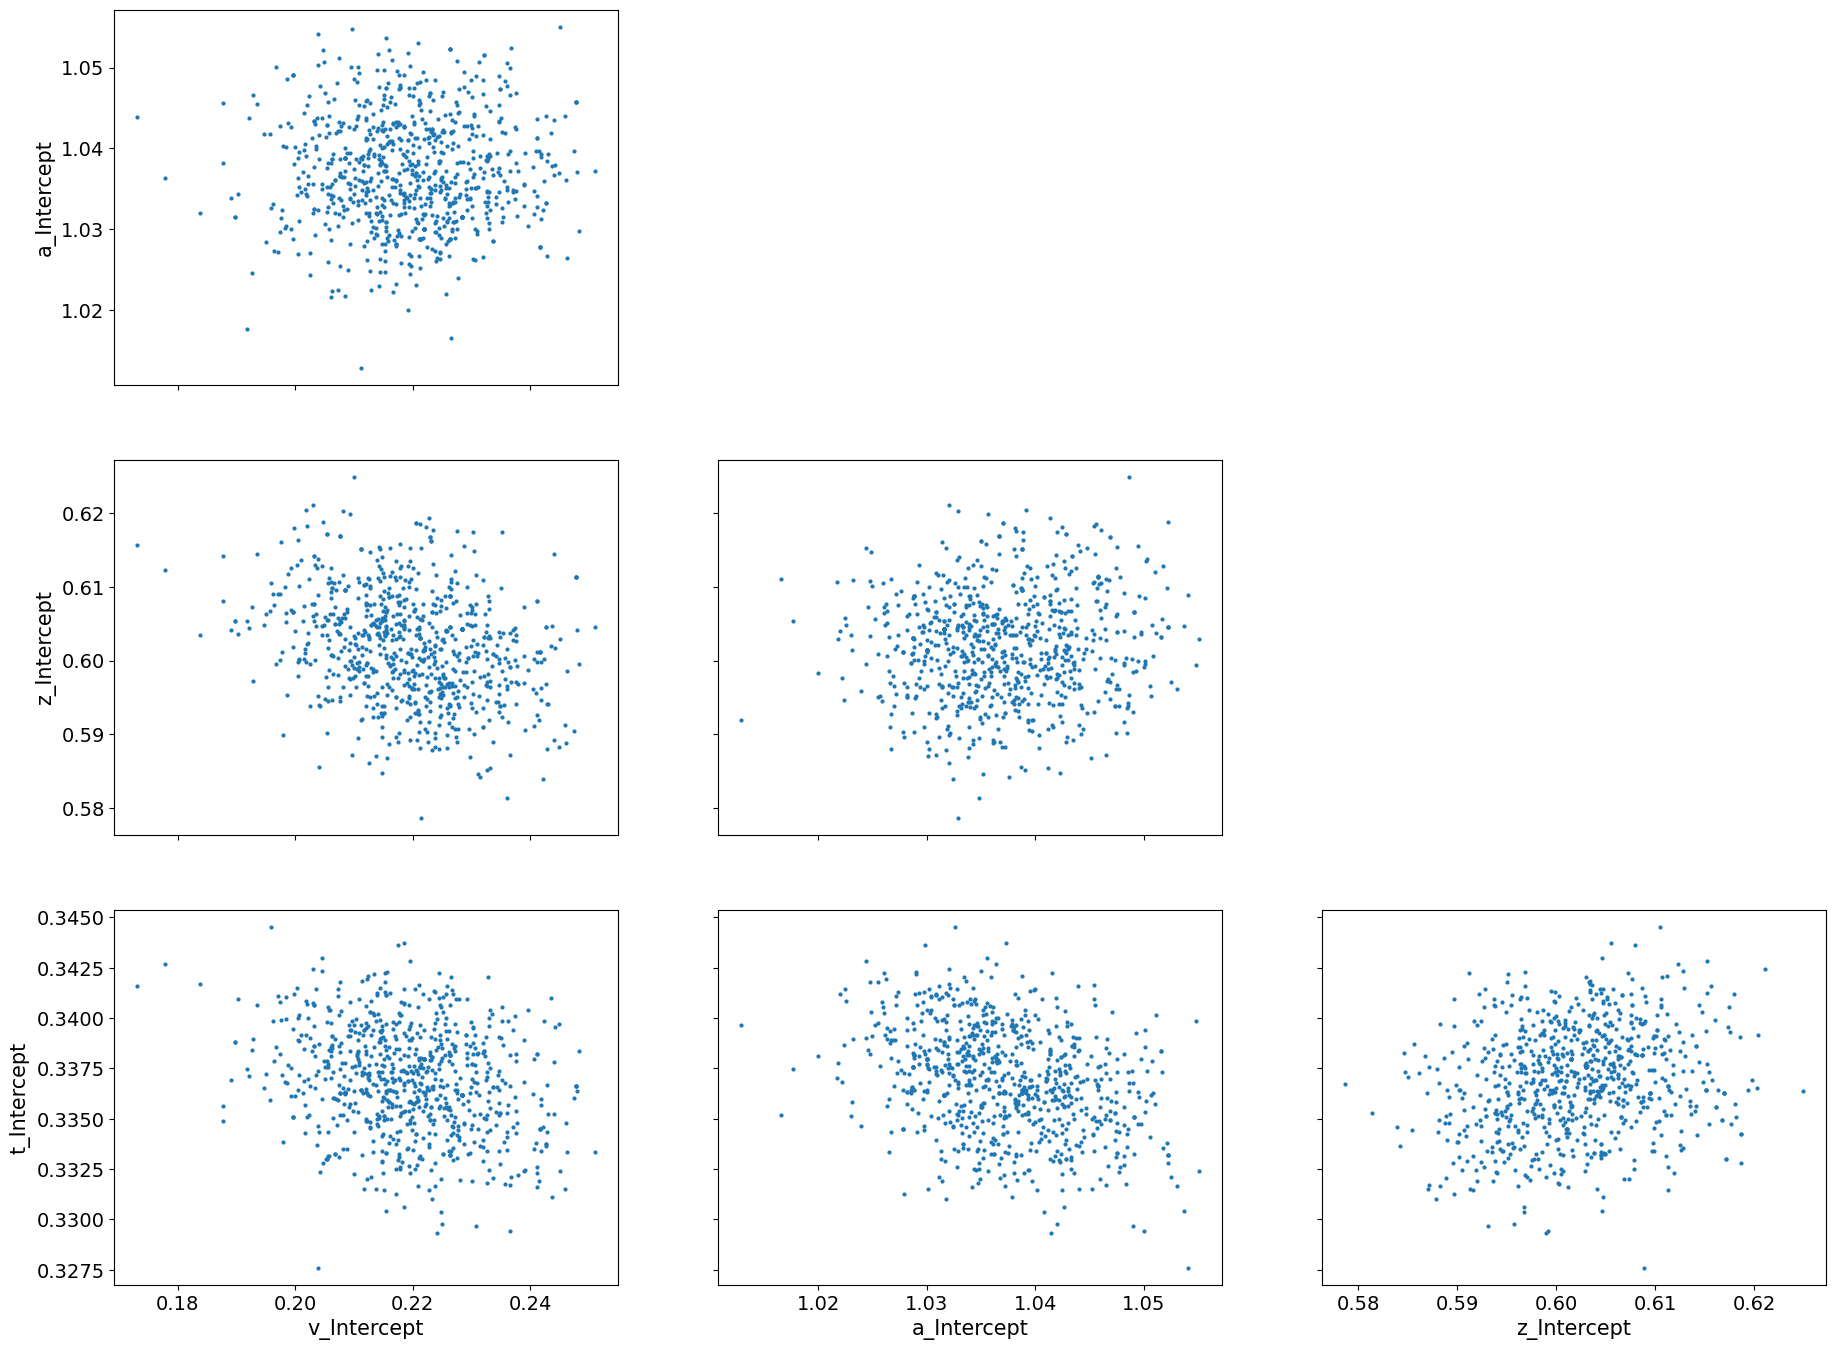

In [ ]:
az.plot_pair(inferenceData_ddm_simple_allFree_hier_even,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

## inference on dataForModel

In [5]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_hier_dataForModel.nc'
ddm_inferenceData=az.from_netcdf(fileName)
ddm_inferenceData

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or n

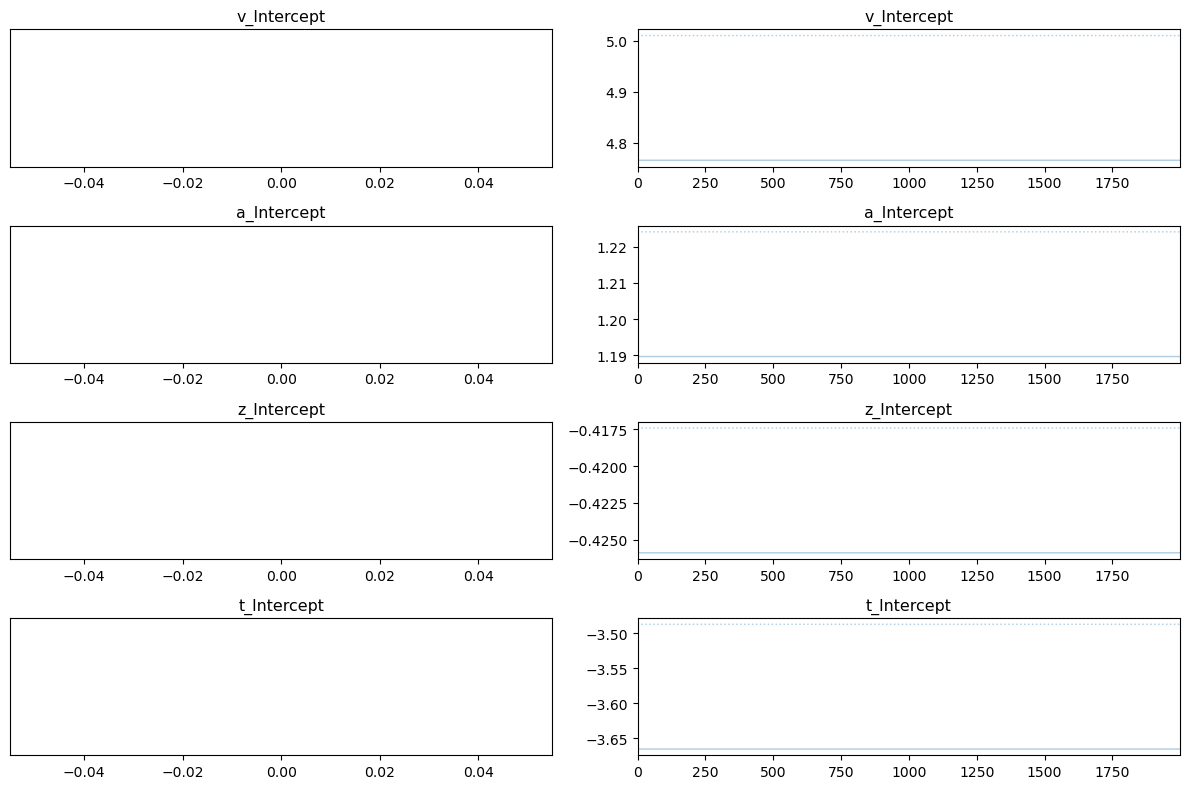

In [6]:
az.plot_trace(
    ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

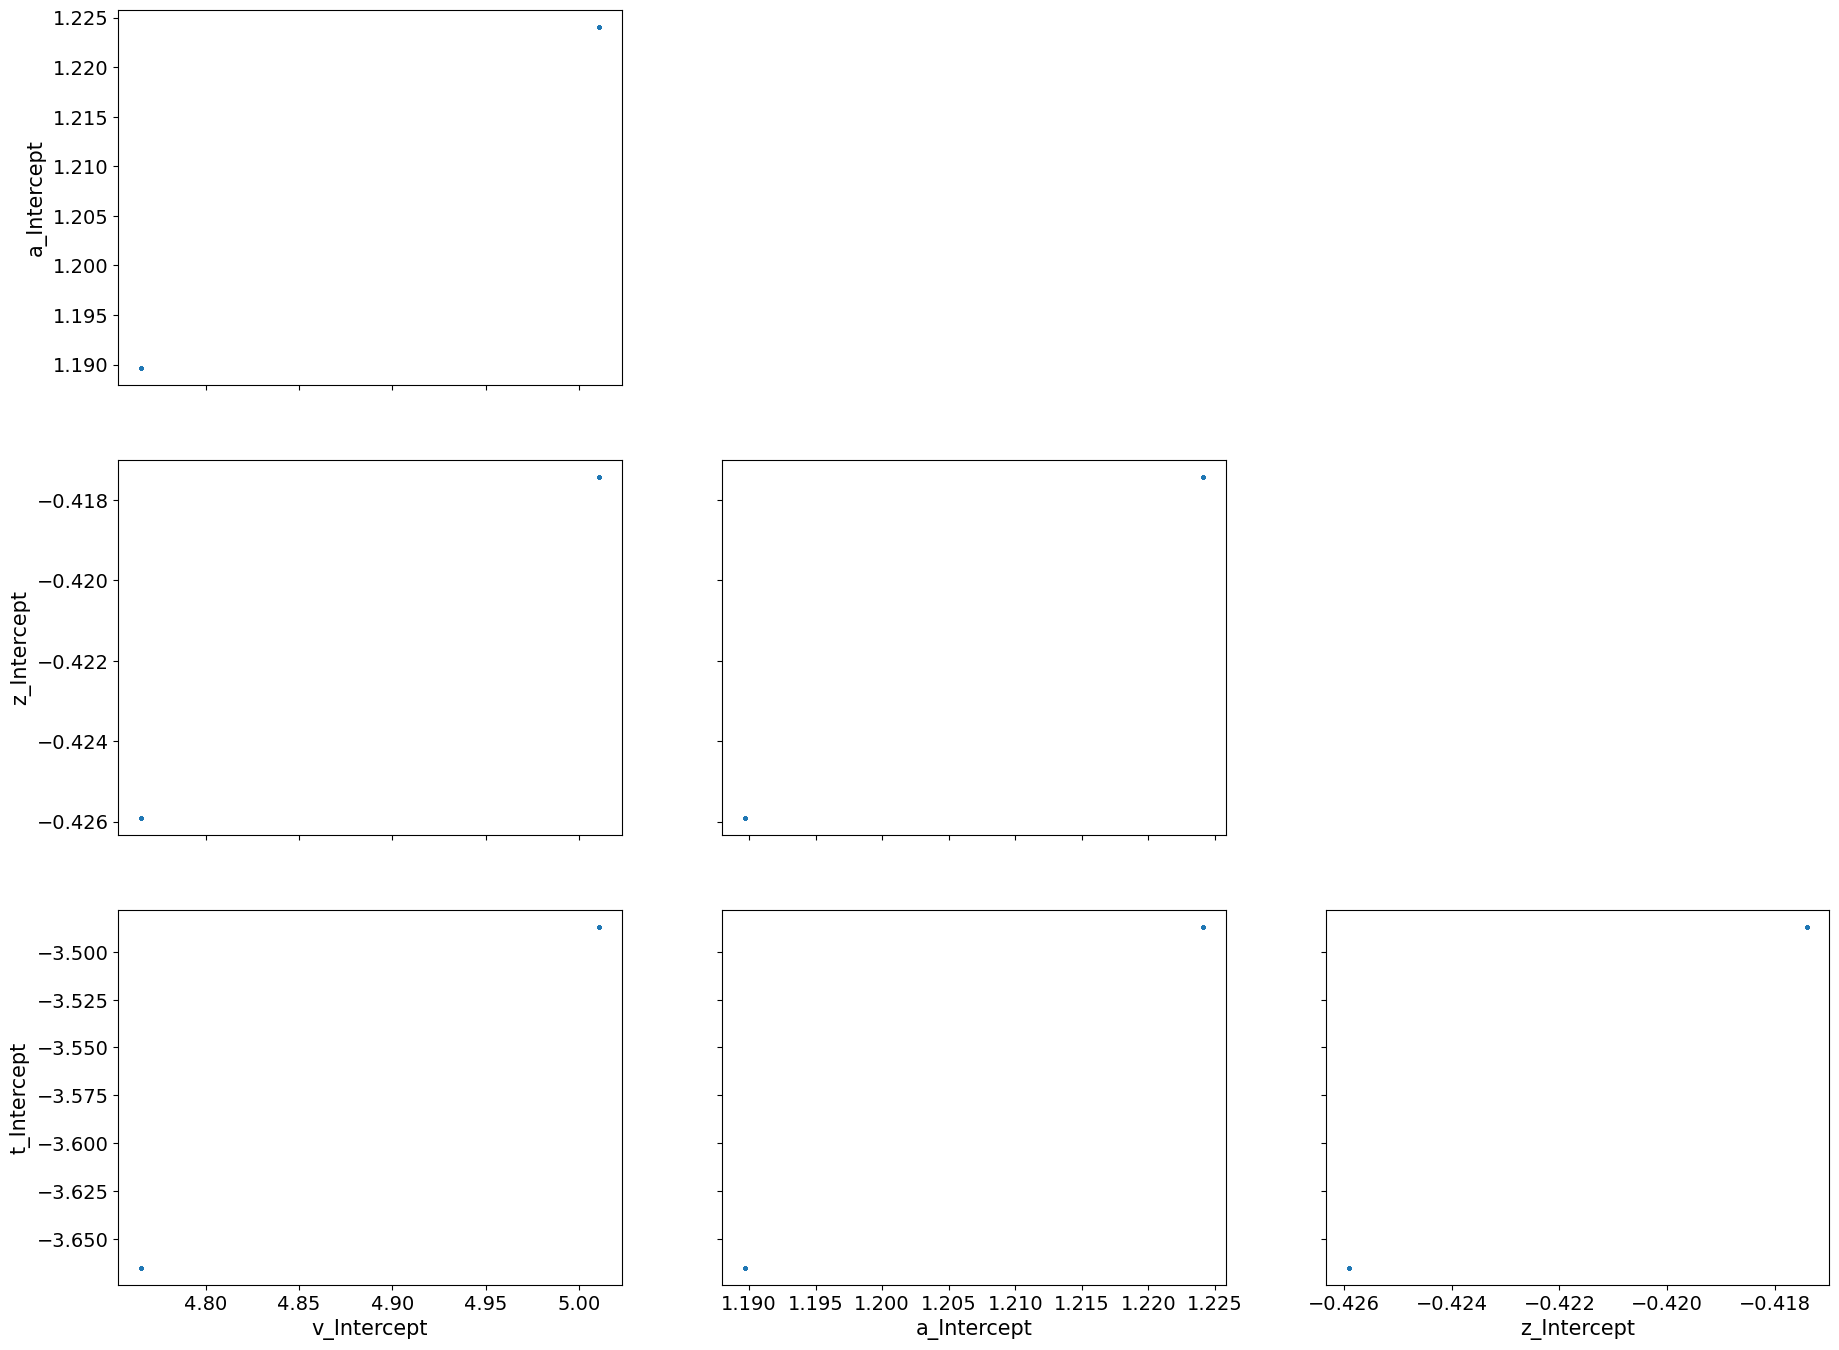

In [7]:
az.plot_pair(ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

# check single sub data

In [29]:
subNum=5
subID=day2SubList[subNum]

In [30]:
fileName = basepath + '/models/ddm/sept24/numpyro/singleSub/'+ str(subID)+'/inferenceData_ddm_simple_allFree'+str(subID)+'_.nc'
ddm_inferenceData_singleSub=az.from_netcdf(fileName)
ddm_inferenceData_singleSub

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

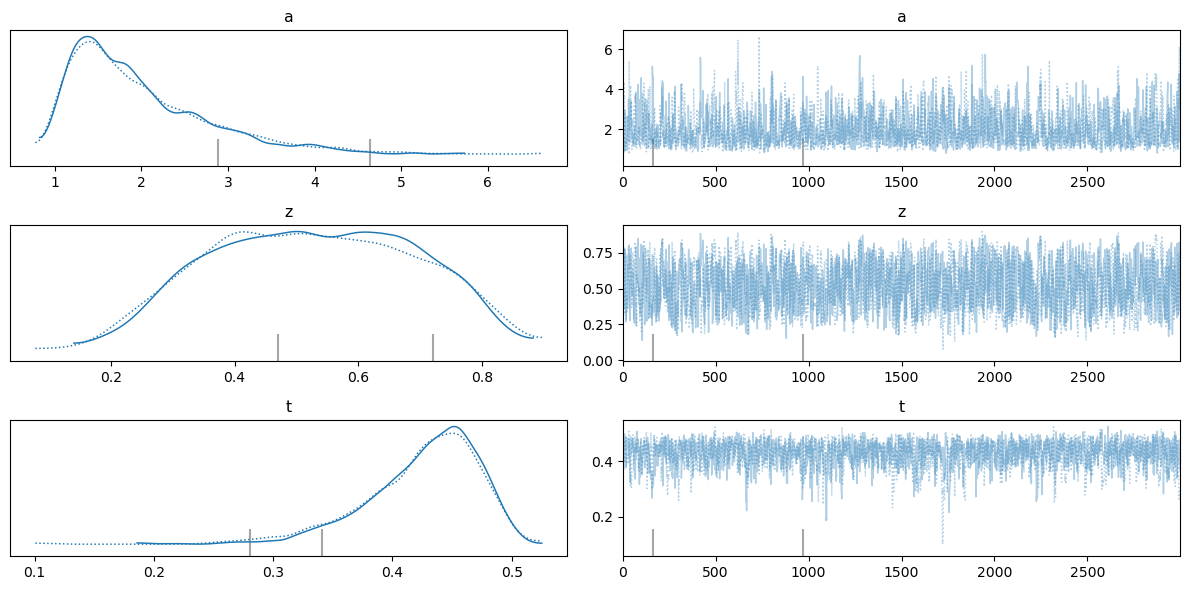

In [31]:
az.plot_trace(
    ddm_inferenceData_singleSub,var_names=['a','z','t']
)
plt.tight_layout()



array([[<Axes: ylabel='z'>, <Axes: >],
       [<Axes: xlabel='a', ylabel='t'>, <Axes: xlabel='z'>]], dtype=object)

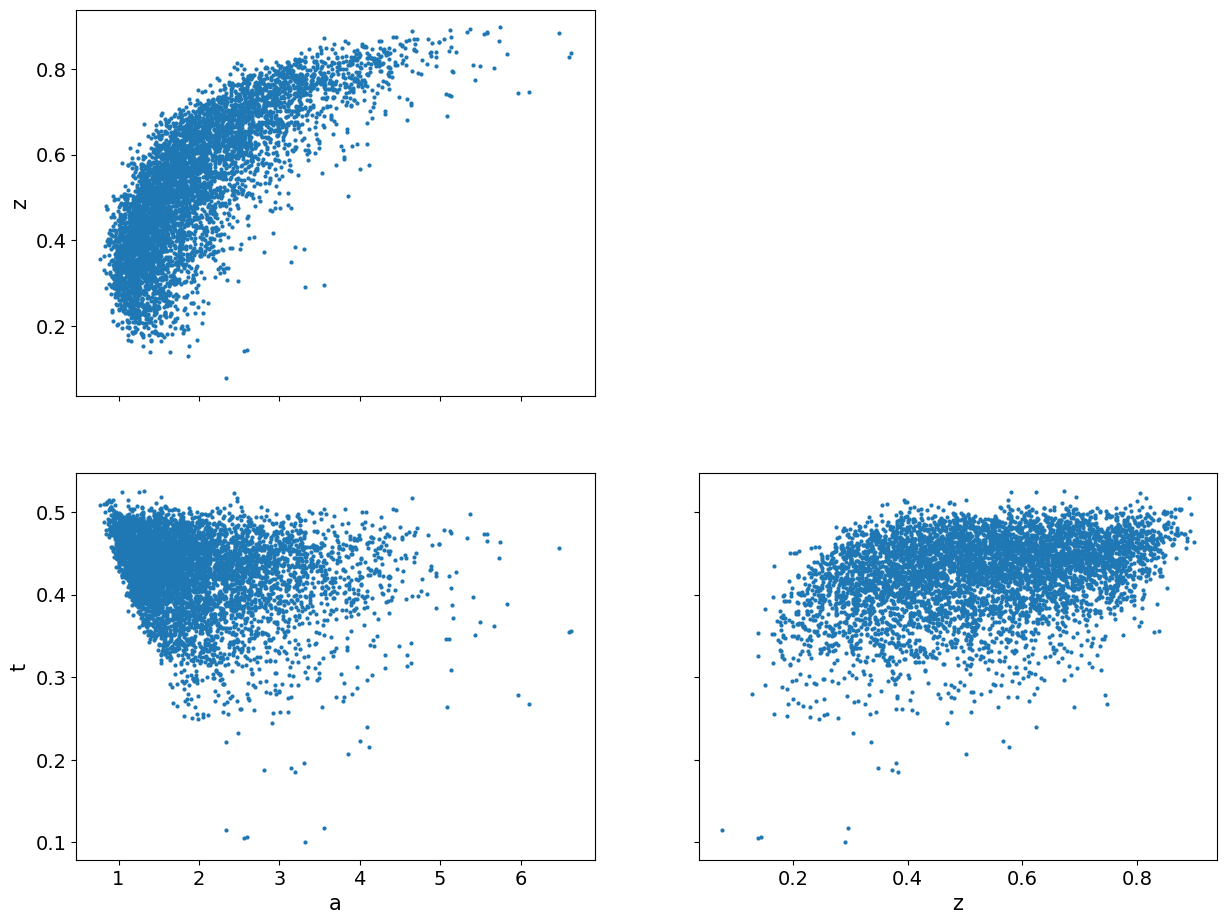

In [32]:
az.plot_pair(ddm_inferenceData_singleSub,var_names=['a','z','t'])

In [61]:
day2SubList[70]

62433

In [20]:
len(day2SubList)

71

In [21]:
skipped_subjects_traces = []
for subNum in range(len(day2SubList)):
    try:
        subID = day2SubList[subNum]
        print(subID)
        fileName = basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_ddm_simple_allFree' + str(subID) + '_.nc'
        ddm_inferenceData_singleSub = az.from_netcdf(fileName)
        
        # Plotting trace
        az.plot_trace(ddm_inferenceData_singleSub, var_names=['a', 'z', 't'])
        plt.tight_layout()
        
        # Saving the plot
        plt.savefig(basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/singleSub_traces_' + str(subID) + '_.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    except OverflowError as e:
        print(f"Skipping subID {subID}: {e}")
        skipped_subjects_traces.append(subID)
         # Close the plot to prevent it from displaying
        plt.close()
    except Exception as e:
        print(f"An unexpected error occurred for subID {subID}: {e}")
        skipped_subjects_traces.append(subID)
         # Close the plot to prevent it from displaying
        plt.close()

42013
42023
42033
42053
42063
42073
42043
42083
42123
42143
42163
42103
42153
42173
42183
42203
42233
42293
42283
42273
42313
42213
42253
42323
42343
42353
42363
42373
42403
42133
42383
42303
42393
42413
42423
42263
62103
62073
62173
62093
62133
62123
62143
62193
62113
62263
62293
62273


/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


62153
62283
62163
62043
62023
62253
62213
62233
62013
62323
62333
62063
62343
62363
62313
62393
62373
62423
62413
62443
62303
62403
62433


In [22]:
print("Skipped subjects for trace plots:", skipped_subjects_traces)


Skipped subjects for trace plots: []


In [24]:
skipped_subjects_pair = []
for subNum in range(len(day2SubList)):
    try:
        subID = day2SubList[subNum]
        fileName = basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/inferenceData_ddm_simple_allFree' + str(subID) + '_.nc'
        ddm_inferenceData_singleSub = az.from_netcdf(fileName)
        
        # Plotting posterior pair
        az.plot_pair(ddm_inferenceData_singleSub,var_names=['a','z','t'])
        plt.tight_layout()
        
        # Saving the plot
        plt.savefig(basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/singleSub_posteriorPair_' + str(subID) + '_.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    except OverflowError as e:
        print(f"Skipping subID {subID}: {e}")
        skipped_subjects_pair.append(subID)
    except Exception as e:
        print(f"An unexpected error occurred for subID {subID}: {e}")
        skipped_subjects_pair.append(subID)

In [49]:
print("Skipped subjects for pair plots:", skipped_subjects_pair)

Skipped subjects for pair plots: []


## look at specific sub data based on inference results

### good subs

In [10]:
subIDs=[42033,62103]
subIDs

[42033, 62103]

In [6]:
subID=42033
subNum = np.where(day2SubList == subID)[0][0]
subNum

2

In [6]:
oddballDataDay2

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       1.0  
1                       1.0        -0.174549        -0.033526       1.0  
2                       3.0         0.289645         1.666682       1.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       1.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       1.0  
11285                   1.0        -0.197492        -0.575755       1.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       1.0  
11288                   1.0        -0.133665        -0.081732       1.0  

[11227 rows x 23 columns]

In [7]:
subAllData=oddballDataDay2[oddballDataDay2.participant_id==subID]
subAllData

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
318              3           42033       1   24592   27092   -1250   
319              3           42033       1   28574   31074   -1250   
320              3           42033       1   30574   33074   -1250   
321              3           42033       1   33574   36074   -1250   
322              3           42033       1   35574   38074   -1250   
..             ...             ...     ...     ...     ...     ...   
472              3           42033       1  457612  460112   -1250   
473              3           42033       1  459612  462112   -1250   
474              3           42033       1  464612  467112   -1250   
475              3           42033       1  466612  469112   -1250   
476              3           42033       1  469612  472112   -1250   

     trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
318               1     69       16        1  ...     1.146176  0.354354   
319               2     73       16        1  ...     0.515181  0.926753   
320               3     77       16        1  ...    -0.313960  0.548601   
321               4     81       16        1  ...     0.747735 -0.668490   
322               5     85       16        1  ...    -1.712360  1.143714   
..              ...    ...      ...      ...  ...          ...       ...   
472             155    684       16        1  ...    -1.068918  0.217498   
473             156    688       16        1  ...    -0.727919  0.354990   
474             157    692       16        1  ...     0.828068 -0.013449   
475             158    696       16        1  ...     1.025334 -0.038046   
476             159    700       16        1  ...     1.325872  3.196150   

        pupil       LCr  trl_condition_bin    switch_condition  \
318  0.845230  0.504033                  1                 NaN   
319  0.872802  0.504033                  1       stay_standard   
320  0.760891  0.504033                  2   switch_to_oddball   
321 -1.061869  0.504033                  2        stay_oddball   
322  0.253740  0.504033                  1  switch_to_standard   
..        ...       ...                ...                 ...   
472 -0.301183  0.504033                  1       stay_standard   
473  0.230301  0.504033                  1       stay_standard   
474  0.954814  0.504033                  2   switch_to_oddball   
475  2.197444  0.504033                  1  switch_to_standard   
476  1.425795  0.504033                  1       stay_standard   

     switch_condition_num  logreactiontime logreactiontimez  response  
318                   NaN         0.363933         2.088124       1.0  
319                   1.0        -0.176851         0.150667       1.0  
320                   3.0        -0.074723         0.516560       1.0  
321                   2.0        -0.292870        -0.264991       1.0  
322                   4.0        -0.254678        -0.128162       1.0  
..                    ...              ...              ...       ...  
472                   1.0        -0.183219         0.127852       1.0  
473                   1.0        -0.285261        -0.237733       1.0  
474                   3.0        -0.200946         0.064343       1.0  
475                   4.0        -0.254892        -0.128930       1.0  
476                   1.0        -0.416891        -0.709319       1.0  

[158 rows x 23 columns]

/tmp/ipykernel_459427/2372461602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']


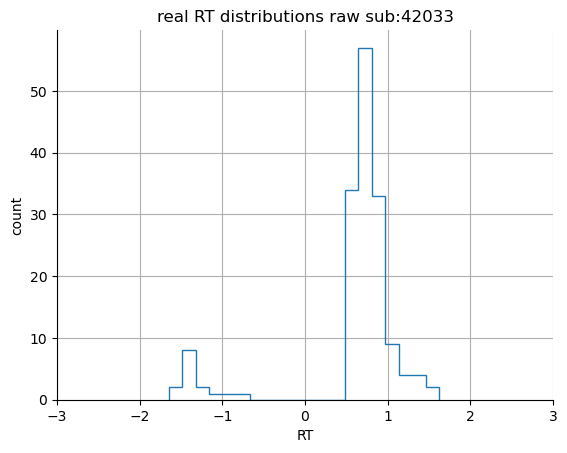

In [8]:
subAllData['rtPlot']=subAllData['rt']
subAllData.loc[subAllData['response'] == -1,'rtPlot']=subAllData.loc[subAllData['response'] == -1,'rtPlot']*-1
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw sub:'+ str(subID))
for i, subj_data in subAllData.groupby('participant_id'):
    subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

# Remove the top and right spines (the outer box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(-3,3)   
plt.savefig(basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/RT_dist_plot_' + str(subID) + '.jpg')

#### loop

In [13]:
subIDs=[42033,62103]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2[oddballDataDay2.participant_id==subID]

        subAllData['rtPlot']=subAllData['rt']
        subAllData.loc[subAllData['response'] == -1,'rtPlot']=subAllData.loc[subAllData['response'] == -1,'rtPlot']*-1
        fig = plt.figure()
        ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw sub:'+ str(subID))
        for i, subj_data in subAllData.groupby('participant_id'):
                subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

        # Remove the top and right spines (the outer box)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xlim(-3,3)   
        plt.savefig(basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/RT_dist_plot_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    

42033
62103
42133


/tmp/ipykernel_459427/2125463039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/2125463039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/2125463039.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

#### big panel plot

42033
62103


/tmp/ipykernel_1606461/1300139655.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']
/tmp/ipykernel_1606461/1300139655.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']


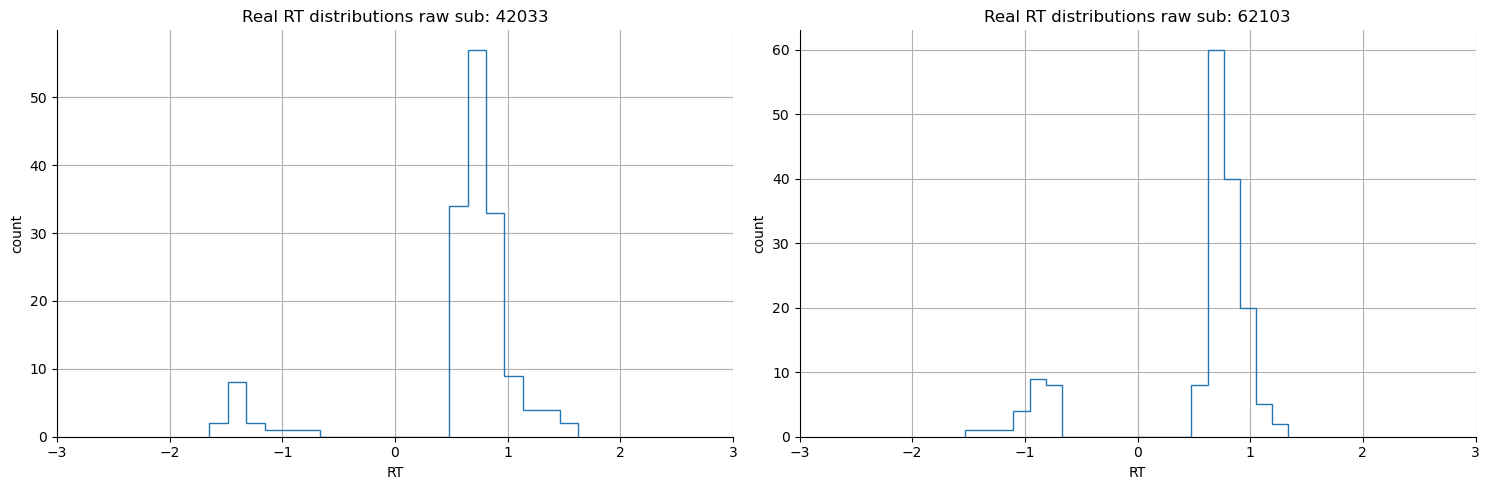

In [6]:
subIDs = [42033, 62103]

# Create a figure with a grid of subplots (1 row, len(subIDs) columns)
fig, axs = plt.subplots(1, len(subIDs), figsize=(15, 5))  # Adjust figsize as needed

for s in range(len(subIDs)):
    subID = subIDs[s]
    print(subID)

    subAllData = oddballDataDay2[oddballDataDay2.participant_id == subID]

    subAllData['rtPlot'] = subAllData['rt']
    subAllData.loc[subAllData['response'] == -1, 'rtPlot'] = subAllData.loc[subAllData['response'] == -1, 'rtPlot'] * -1
    
    ax = axs[s]  # Get the corresponding subplot axis
    ax.set_xlabel('RT')
    ax.set_ylabel('count')
    ax.set_title(f'Real RT distributions raw sub: {subID}')
    
    for i, subj_data in subAllData.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

    # Remove the top and right spines (the outer box)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-3, 3)

# Adjust layout to make sure plots are not overlapping
plt.tight_layout()

# Save the entire figure
plt.savefig(basepath + '/models/ddm/sept24/numpyro/goodSubs_RT_dist_plots_combined.jpg')


### stuck subs

#### loop

In [14]:
subIDs = [
    42023, 42043, 42053, 42063, 42073, 42083, 42103, 42123, 42143, 42153, 
    42183, 42213, 42253, 42273, 42283, 42293, 42313, 42353, 42363, 42373, 
    42383, 42403, 42423, 62013, 62023, 62043, 62063, 62073, 62093, 62113, 
    62123, 62133, 62143, 62153, 62163, 62173, 62193, 62213, 62233, 62253, 
    62263, 62283, 62293, 62313, 62323, 62333, 62363, 62373, 62393, 62403, 
    62413, 62423, 62443
]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2[oddballDataDay2.participant_id==subID]

        subAllData['rtPlot']=subAllData['rt']
        subAllData.loc[subAllData['response'] == -1,'rtPlot']=subAllData.loc[subAllData['response'] == -1,'rtPlot']*-1
        fig = plt.figure()
        ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw sub:'+ str(subID))
        for i, subj_data in subAllData.groupby('participant_id'):
                subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

        # Remove the top and right spines (the outer box)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xlim(-3,3)   
        plt.savefig(basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/RT_dist_plot_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    

42023
42043
42053


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42063
42073
42083


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42103
42123
42143


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42153
42183
42213


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42253
42273
42283


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42293
42313
42353


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42363
42373
42383


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42403
42423
62013


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62023
62043
62063


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62073


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']


62093
62113
62123


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62133
62143
62153


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62163
62173
62193


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62213
62233
62253


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62263
62283
62293


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62313
62323
62333


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62363
62373
62393


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62403
62413
62423


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62443


/tmp/ipykernel_459427/4150144995.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']


#### big panel plot

/tmp/ipykernel_1606461/1731602880.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']
/tmp/ipykernel_1606461/1731602880.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']
/tmp/ipykernel_1606461/1731602880.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

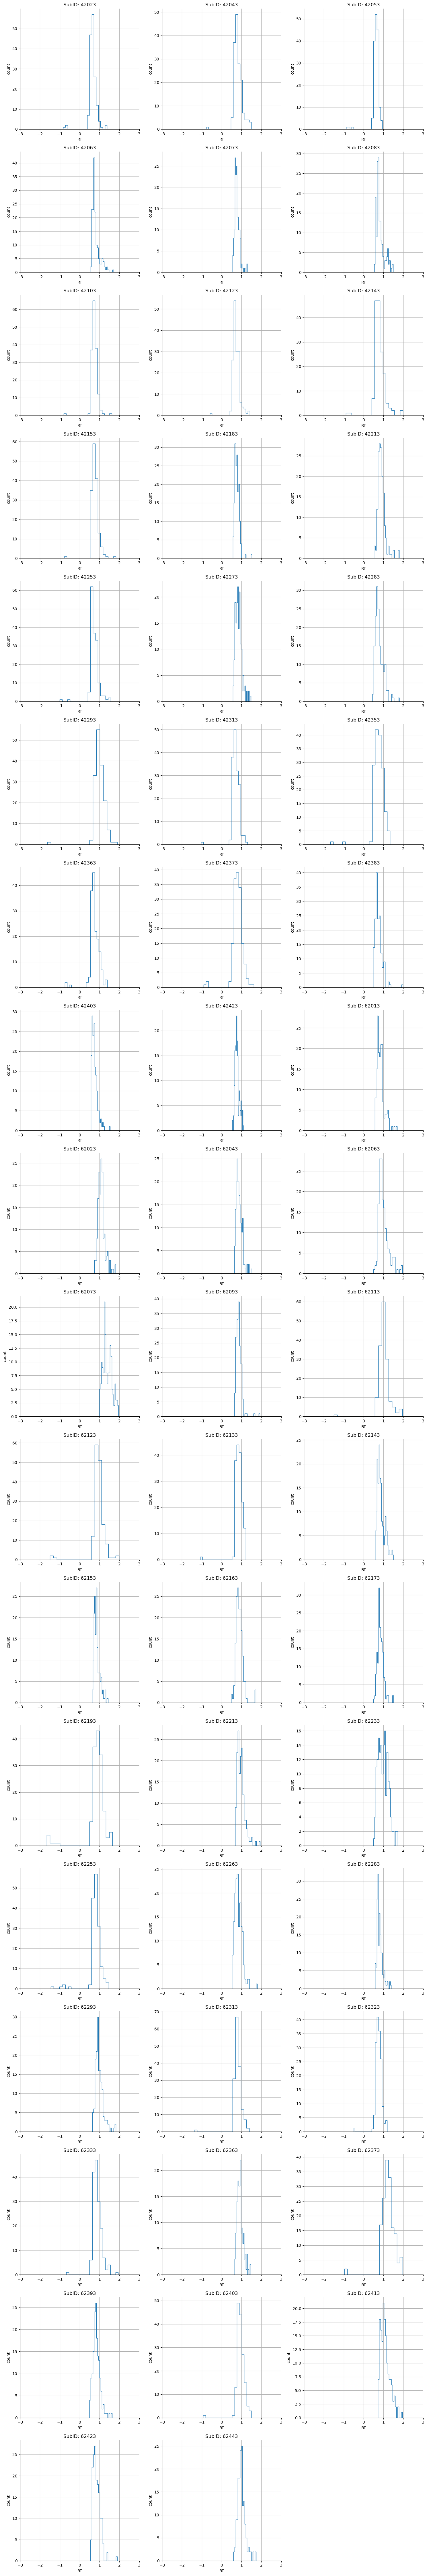

In [9]:
subIDs = [
    42023, 42043, 42053, 42063, 42073, 42083, 42103, 42123, 42143, 42153, 
    42183, 42213, 42253, 42273, 42283, 42293, 42313, 42353, 42363, 42373, 
    42383, 42403, 42423, 62013, 62023, 62043, 62063, 62073, 62093, 62113, 
    62123, 62133, 62143, 62153, 62163, 62173, 62193, 62213, 62233, 62253, 
    62263, 62283, 62293, 62313, 62323, 62333, 62363, 62373, 62393, 62403, 
    62413, 62423, 62443
]

# Calculate the grid size for the subplots (we'll use a square grid if possible)
n_subs = len(subIDs)
n_cols = 3
n_rows = math.ceil(len(subIDs) / n_cols)

# Create a figure with a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figsize for larger plots
axs = axs.flatten()  # Flatten the grid into a 1D array for easier indexing

for s in range(len(subIDs)):
    subID = subIDs[s]
    #print(subID)

    subAllData = oddballDataDay2[oddballDataDay2.participant_id == subID]

    subAllData['rtPlot'] = subAllData['rt']
    subAllData.loc[subAllData['response'] == -1, 'rtPlot'] = subAllData.loc[subAllData['response'] == -1, 'rtPlot'] * -1
    
    ax = axs[s]  # Select the subplot
    ax.set_xlabel('RT')
    ax.set_ylabel('count')
    ax.set_title(f'SubID: {subID}')
    
    for i, subj_data in subAllData.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

    # Remove the top and right spines (the outer box)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-3, 3)

# Hide any unused subplots if the grid is larger than the number of plots
for i in range(len(subIDs), len(axs)):
    fig.delaxes(axs[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the entire figure with all subplots
plt.savefig(basepath + '/models/ddm/sept24/numpyro/stuckSubs_RT_dist_plots_combined.jpg')


In [10]:
n_subs

53

### param trade off

#### loop

In [5]:
subIDs = [
    42013, 42133, 42173, 42203, 42233, 42303, 42323, 42393, 62303
]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2[oddballDataDay2.participant_id==subID]

        subAllData['rtPlot']=subAllData['rt']
        subAllData.loc[subAllData['response'] == -1,'rtPlot']=subAllData.loc[subAllData['response'] == -1,'rtPlot']*-1
        fig = plt.figure()
        ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw sub:'+ str(subID))
        for i, subj_data in subAllData.groupby('participant_id'):
                subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

        # Remove the top and right spines (the outer box)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xlim(-3,3)   
        plt.savefig(basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/RT_dist_plot_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    

42013
42173
42203


/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42233
42303


/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']


42323
42393
62303


/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

62433


/tmp/ipykernel_463087/2174885759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']


#### big panel plot

42013
42133
42173
42203
42233
42303
42323
42393
62303


/tmp/ipykernel_1606461/2944959753.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']
/tmp/ipykernel_1606461/2944959753.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']
/tmp/ipykernel_1606461/2944959753.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

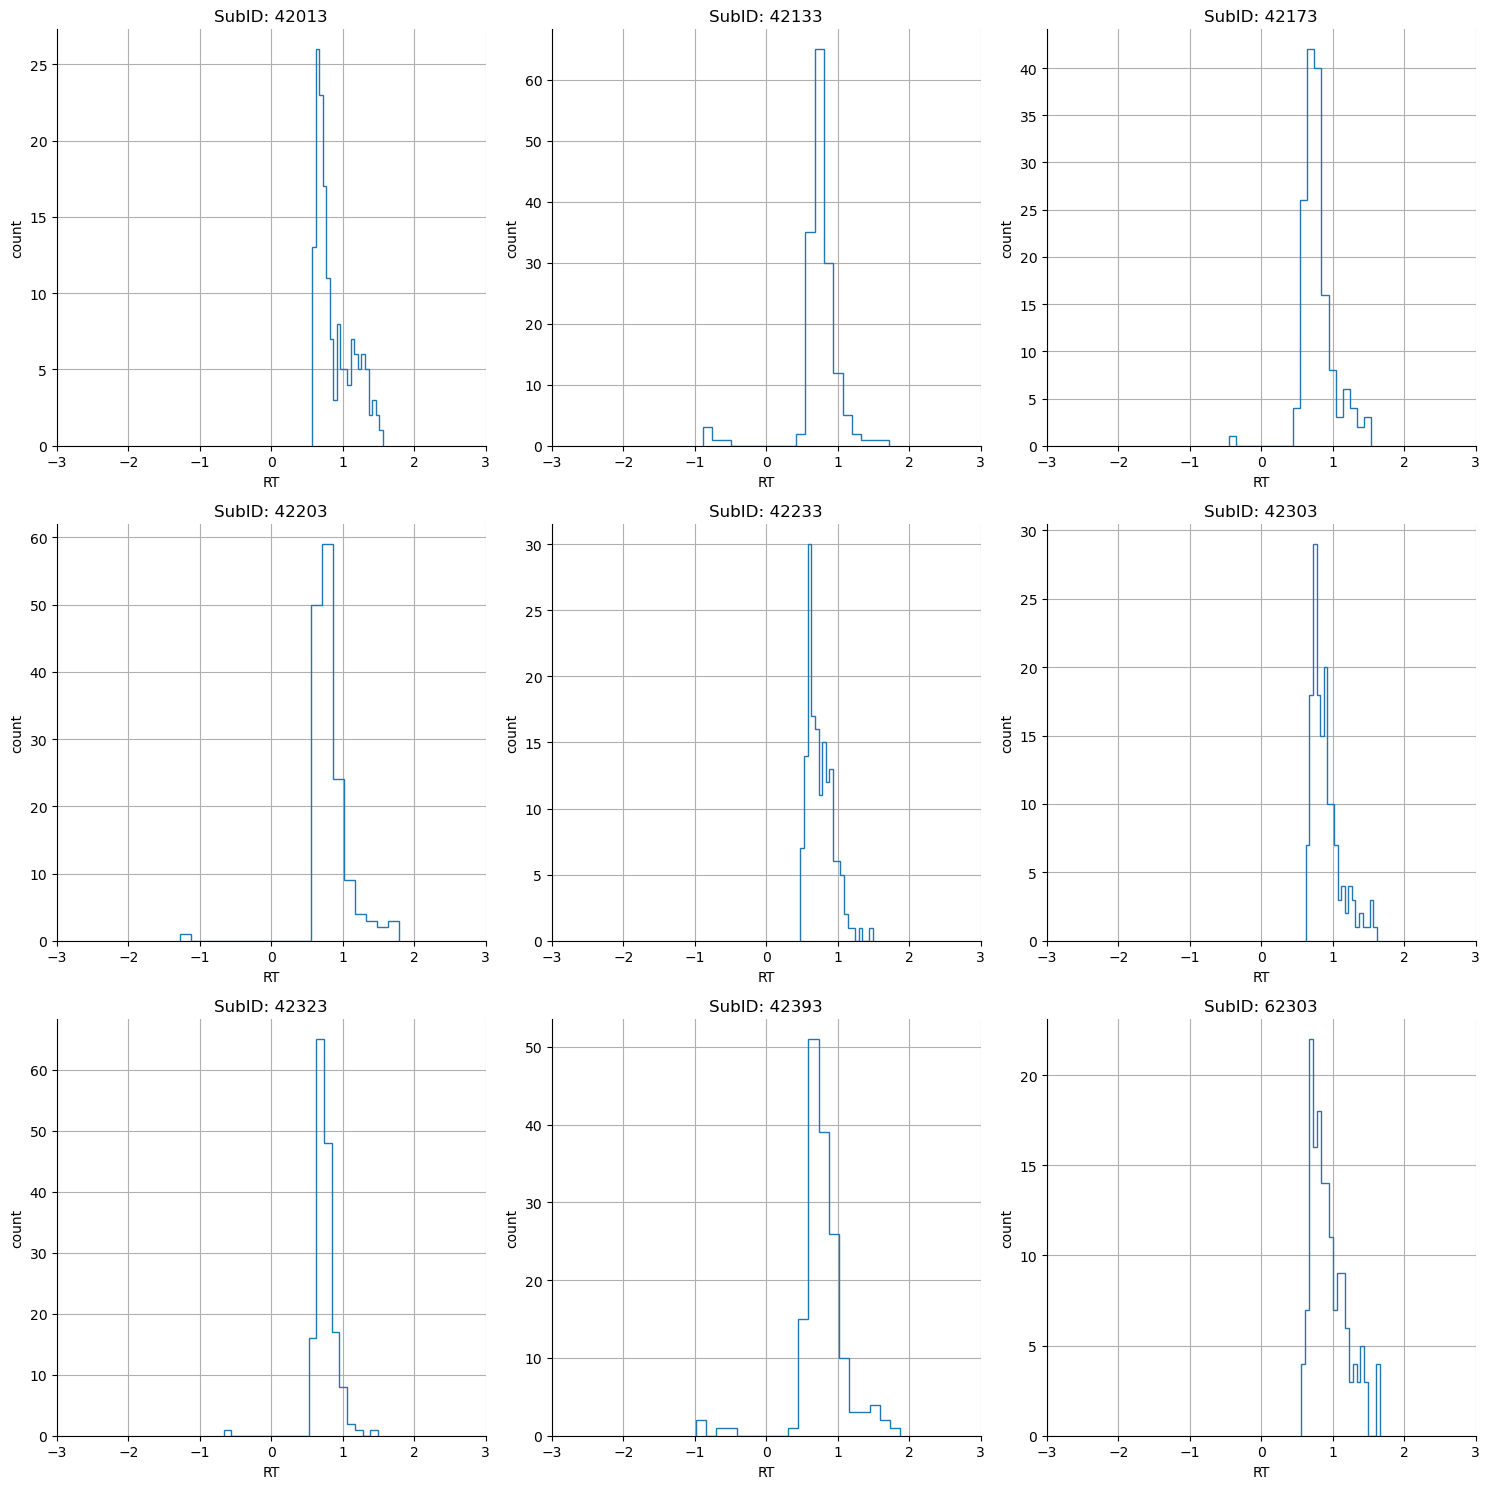

In [8]:
subIDs = [
    42013, 42133, 42173, 42203, 42233, 42303, 42323, 42393, 62303
]

# Set the number of columns to 3
n_cols = 3
n_rows = math.ceil(len(subIDs) / n_cols)

# Create a figure with a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()  # Flatten the grid into a 1D array for easier indexing

for s in range(len(subIDs)):
    subID = subIDs[s]
    print(subID)

    subAllData = oddballDataDay2[oddballDataDay2.participant_id == subID]

    subAllData['rtPlot'] = subAllData['rt']
    subAllData.loc[subAllData['response'] == -1, 'rtPlot'] = subAllData.loc[subAllData['response'] == -1, 'rtPlot'] * -1
    
    ax = axs[s]  # Select the subplot
    ax.set_xlabel('RT')
    ax.set_ylabel('count')
    ax.set_title(f'SubID: {subID}')
    
    for i, subj_data in subAllData.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

    # Remove the top and right spines (the outer box)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-3, 3)

# Hide any unused subplots if the grid is larger than the number of plots
for i in range(len(subIDs), len(axs)):
    fig.delaxes(axs[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the entire figure with all subplots
plt.savefig(basepath + '/models/ddm/sept24/numpyro/paramTradeOffSubs_RT_dist_plots_combined.jpg')


### only one value from inference, problem with trace plot

#### loop

In [6]:
subIDs= [
     42163, 42263, 42343, 42413, 62343, 62433
]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2[oddballDataDay2.participant_id==subID]

        subAllData['rtPlot']=subAllData['rt']
        subAllData.loc[subAllData['response'] == -1,'rtPlot']=subAllData.loc[subAllData['response'] == -1,'rtPlot']*-1
        fig = plt.figure()
        ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw sub:'+ str(subID))
        for i, subj_data in subAllData.groupby('participant_id'):
                subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

        # Remove the top and right spines (the outer box)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xlim(-3,3)   
        plt.savefig(basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/RT_dist_plot_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    

42163
42263
42343


/tmp/ipykernel_463087/2335547778.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_463087/2335547778.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_463087/2335547778.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

42413
62343


/tmp/ipykernel_463087/2335547778.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']
/tmp/ipykernel_463087/2335547778.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']


#### big panel plot

42163
42263
42343
42413
62343
62433


/tmp/ipykernel_1606461/3525809677.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']
/tmp/ipykernel_1606461/3525809677.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']
/tmp/ipykernel_1606461/3525809677.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

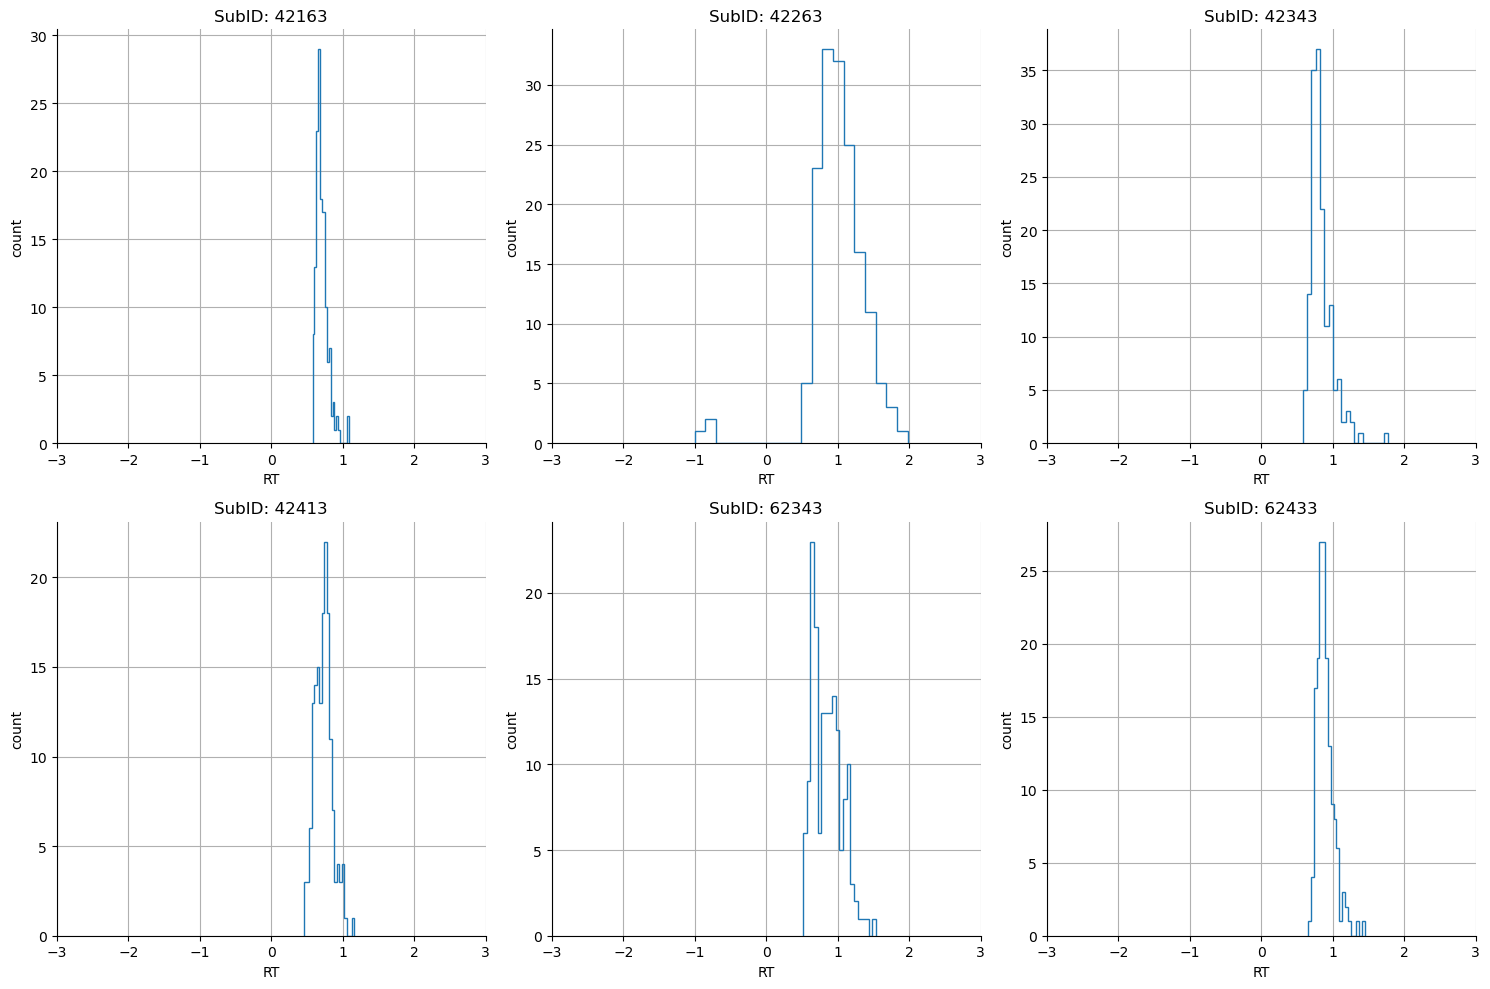

In [11]:
subIDs = [
    42163, 42263, 42343, 42413, 62343, 62433
]

# Set the number of columns to 3
n_cols = 3
n_rows = math.ceil(len(subIDs) / n_cols)

# Create a figure with a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()  # Flatten the grid into a 1D array for easier indexing

for s in range(len(subIDs)):
    subID = subIDs[s]
    print(subID)

    subAllData = oddballDataDay2[oddballDataDay2.participant_id == subID]

    subAllData['rtPlot'] = subAllData['rt']
    subAllData.loc[subAllData['response'] == -1, 'rtPlot'] = subAllData.loc[subAllData['response'] == -1, 'rtPlot'] * -1
    
    ax = axs[s]  # Select the subplot
    ax.set_xlabel('RT')
    ax.set_ylabel('count')
    ax.set_title(f'SubID: {subID}')
    
    for i, subj_data in subAllData.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

    # Remove the top and right spines (the outer box)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-3, 3)

# Hide any unused subplots if the grid is larger than the number of plots
for i in range(len(subIDs), len(axs)):
    fig.delaxes(axs[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the entire figure with all subplots
plt.savefig(basepath + '/models/ddm/sept24/numpyro/onePostValSubs_RT_dist_plots_combined.jpg')


### super bad sub (check trace plot)

#### loop

In [7]:
subIDs = [
    62273
]

for s in range(len(subIDs)):
        subID=subIDs[s]
        print(subID)

        subAllData=oddballDataDay2[oddballDataDay2.participant_id==subID]

        subAllData['rtPlot']=subAllData['rt']
        subAllData.loc[subAllData['response'] == -1,'rtPlot']=subAllData.loc[subAllData['response'] == -1,'rtPlot']*-1
        fig = plt.figure()
        ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='real RT distributions raw sub:'+ str(subID))
        for i, subj_data in subAllData.groupby('participant_id'):
                subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

        # Remove the top and right spines (the outer box)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xlim(-3,3)   
        plt.savefig(basepath + '/models/ddm/sept24/numpyro/singleSub/' + str(subID) + '/RT_dist_plot_' + str(subID) + '.jpg')
        
        # Close the plot to prevent it from displaying
        plt.close()

    

62273


/tmp/ipykernel_463087/2416494448.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot']=subAllData['rt']


#### big panel plot

62273


/tmp/ipykernel_469015/806944805.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subAllData['rtPlot'] = subAllData['rt']


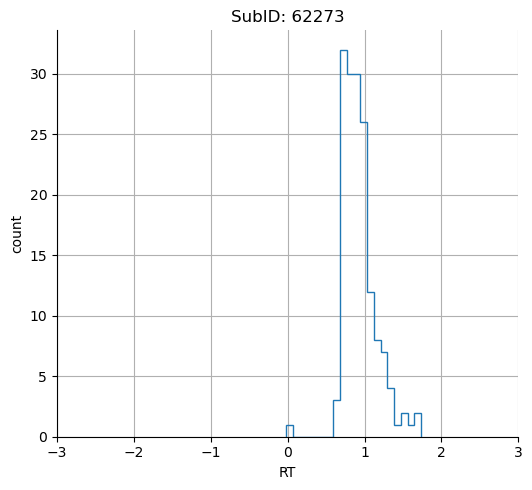

In [12]:
subIDs = [
    62273
]

# Set the number of columns to 3
n_cols = 3
n_rows = math.ceil(len(subIDs) / n_cols)

# Create a figure with a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()  # Flatten the grid into a 1D array for easier indexing

for s in range(len(subIDs)):
    subID = subIDs[s]
    print(subID)

    subAllData = oddballDataDay2[oddballDataDay2.participant_id == subID]

    subAllData['rtPlot'] = subAllData['rt']
    subAllData.loc[subAllData['response'] == -1, 'rtPlot'] = subAllData.loc[subAllData['response'] == -1, 'rtPlot'] * -1
    
    ax = axs[s]  # Select the subplot
    ax.set_xlabel('RT')
    ax.set_ylabel('count')
    ax.set_title(f'SubID: {subID}')
    
    for i, subj_data in subAllData.groupby('participant_id'):
        subj_data.rtPlot.hist(bins=20, histtype='step', ax=ax)

    # Remove the top and right spines (the outer box)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-3, 3)

# Hide any unused subplots if the grid is larger than the number of plots
for i in range(len(subIDs), len(axs)):
    fig.delaxes(axs[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the entire figure with all subplots
plt.savefig(basepath + '/models/ddm/sept24/numpyro/veryBadSubs_RT_dist_plots_combined.jpg')


# new hssm with nuts sampler from numpyro

## simplest hierarchical ddm

In [11]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_hier_.nc'
ddm_inferenceData=az.from_netcdf(fileName)
ddm_inferenceData

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

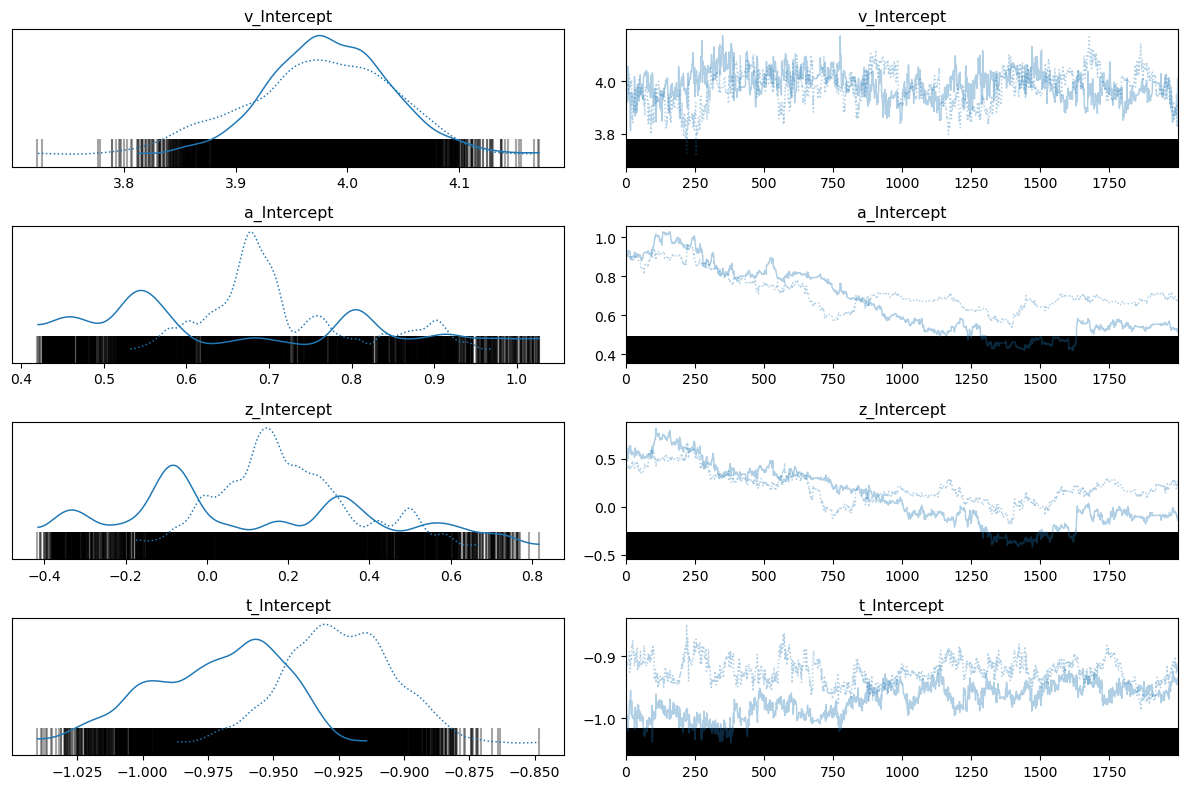

In [12]:
az.plot_trace(
    ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

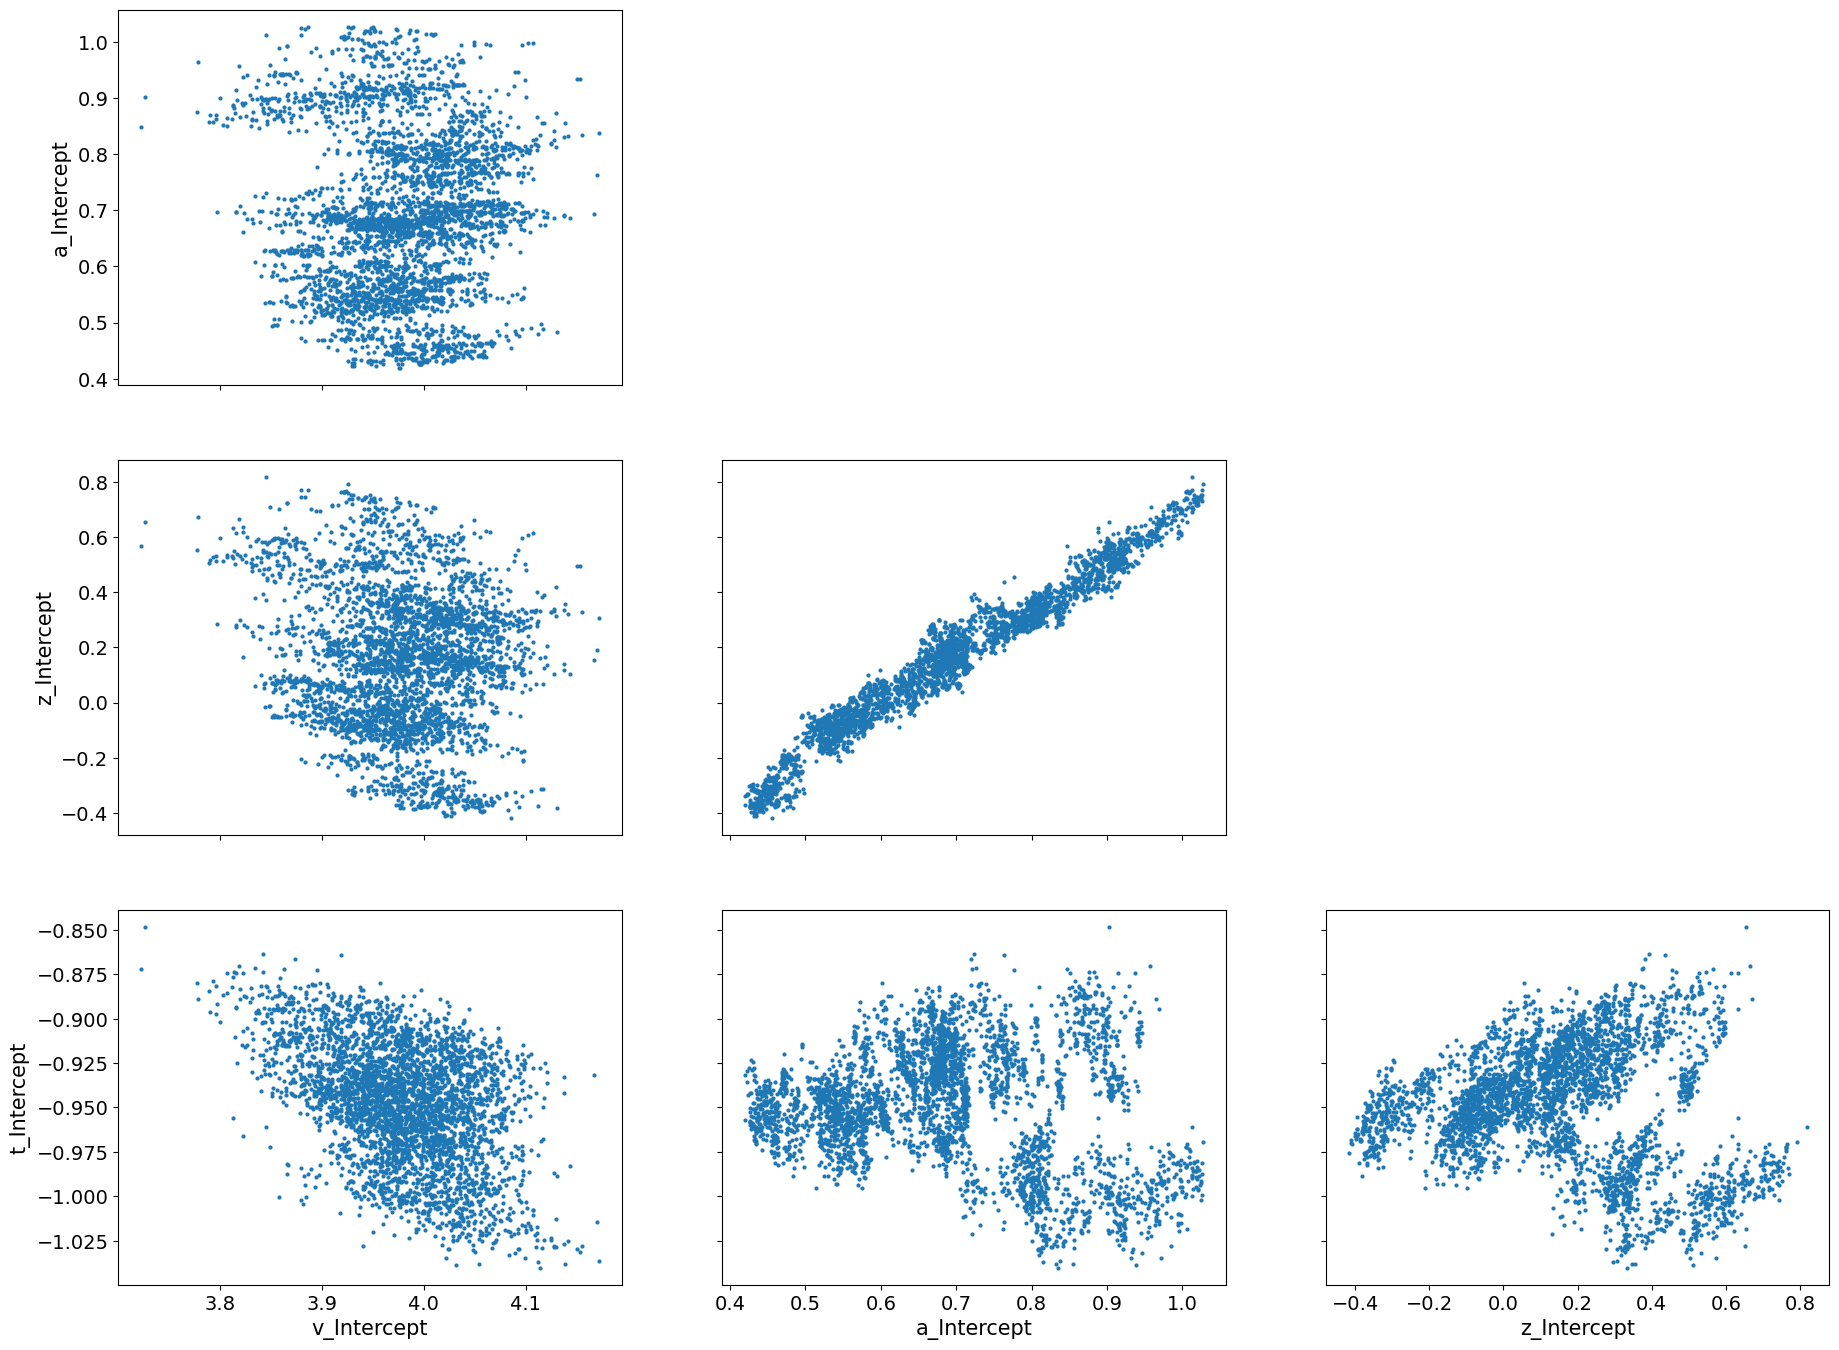

In [13]:
az.plot_pair(ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

In [14]:
az.summary(ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_Intercept  3.979  0.060   3.853    4.081      0.009    0.007      43.0   
a_Intercept  0.690  0.142   0.430    0.925      0.084    0.067       3.0   
z_Intercept  0.151  0.250  -0.356    0.596      0.147    0.116       3.0   
t_Intercept -0.948  0.033  -1.010   -0.891      0.019    0.015       3.0   

             ess_tail  r_hat  
v_Intercept     108.0   1.02  
a_Intercept      19.0   1.90  
z_Intercept      18.0   1.82  
t_Intercept      15.0   1.78

In [19]:
def add_likelihood_parameters_to_idata(
        self,
        idata: az.InferenceData | None = None,
        inplace: bool = False)

SyntaxError: expected ':' (1938837714.py, line 4)

In [ ]:
traces_with_likelihood_parameters = my_model.add_likelihood_parameters_to_idata(idata = my_loaded_idata)

## simplest hier sim data

In [10]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_sim_ddm_simple_allFree_hier_.nc'
ddm_inferenceData=az.from_netcdf(fileName)
ddm_inferenceData

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

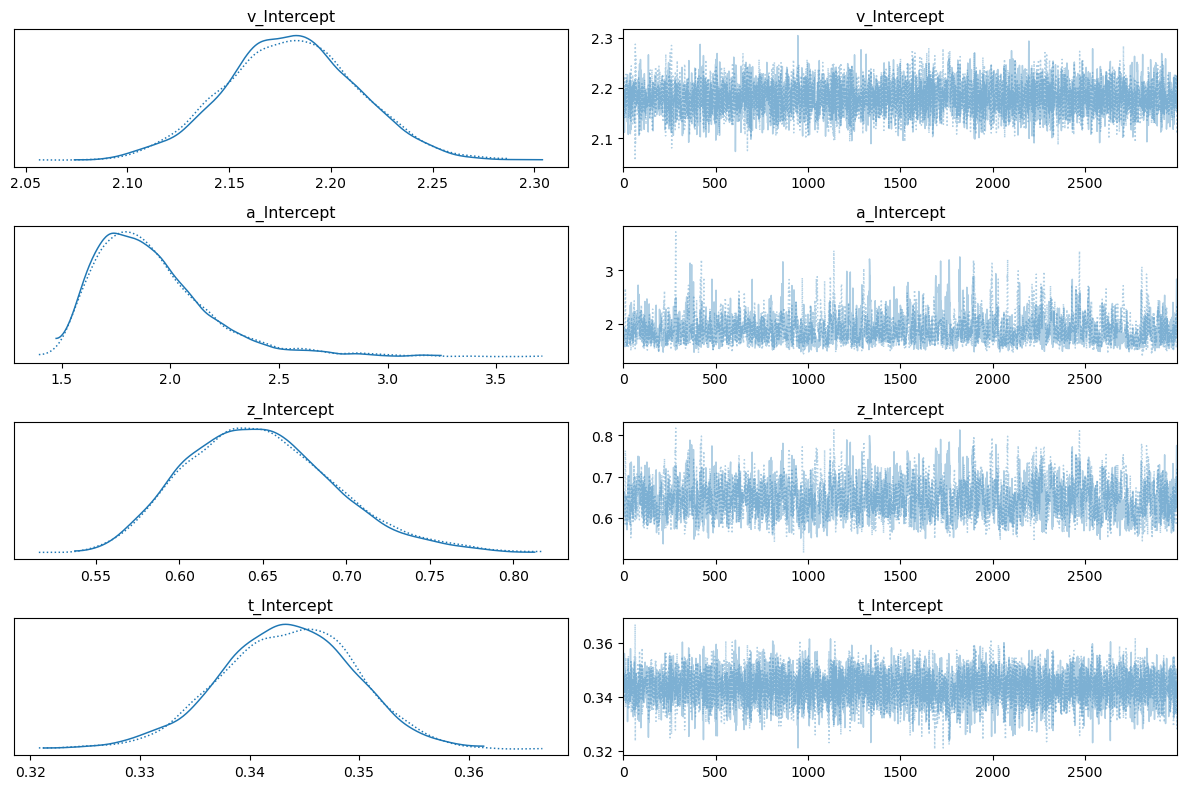

In [11]:
az.plot_trace(
    ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

array([[<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='v_Intercept', ylabel='t_Intercept'>,
        <Axes: xlabel='a_Intercept'>, <Axes: xlabel='z_Intercept'>]],
      dtype=object)

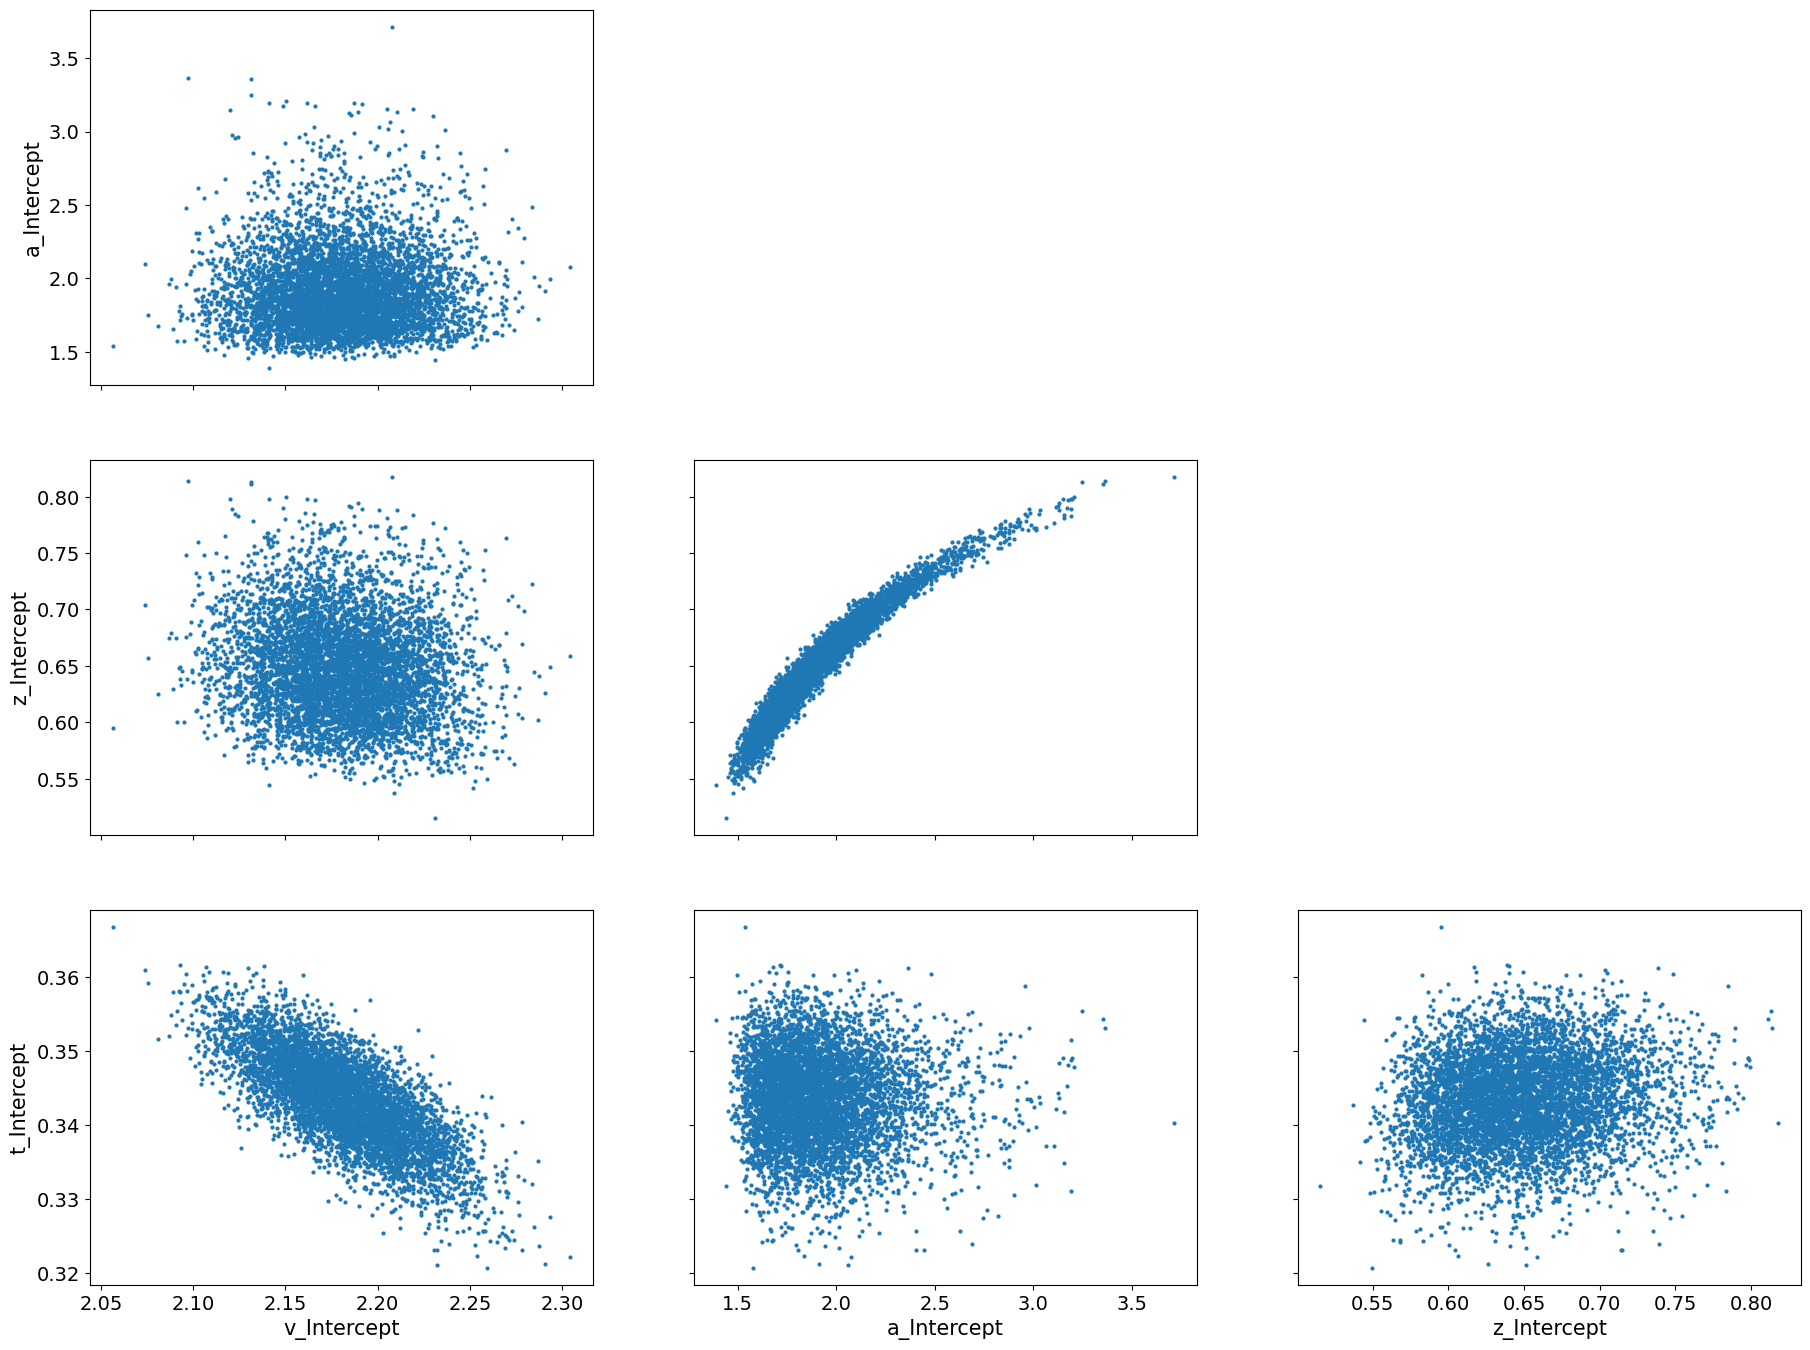

In [12]:
az.plot_pair(ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

In [13]:
az.summary(ddm_inferenceData,var_names=['v_Intercept','a_Intercept','z_Intercept','t_Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_Intercept  2.181  0.032   2.116    2.238      0.000    0.000    7229.0   
a_Intercept  1.911  0.266   1.522    2.407      0.008    0.006     855.0   
z_Intercept  0.649  0.044   0.568    0.731      0.001    0.001     877.0   
t_Intercept  0.343  0.006   0.332    0.355      0.000    0.000    6139.0   

             ess_tail  r_hat  
v_Intercept    4223.0    1.0  
a_Intercept    1518.0    1.0  
z_Intercept    1435.0    1.0  
t_Intercept    4108.0    1.0

# test


In [5]:
oddballDataDay2

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       1.0  
1                       1.0        -0.174549        -0.033526       1.0  
2                       3.0         0.289645         1.666682       1.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       1.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       1.0  
11285                   1.0        -0.197492        -0.575755       1.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       1.0  
11288                   1.0        -0.133665        -0.081732       1.0  

[11227 rows x 23 columns]

In [7]:
subIDs=[42033,62103,42133,42013, 42173, 42203, 42233, 42303, 42323, 42393, 62303, 62433]
subIDs

[42033,
 62103,
 42133,
 42013,
 42173,
 42203,
 42233,
 42303,
 42323,
 42393,
 62303,
 62433]

In [8]:
goodData=oddballDataDay2[oddballDataDay2['participant_id'].isin(subIDs)]

In [9]:
goodData

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
0                  1           42013       1   48306   50806   -1250   
1                  1           42013       1   52293   54793   -1250   
2                  1           42013       1   54293   56793   -1250   
3                  1           42013       1   57293   59793   -1250   
4                  1           42013       1   59293   61793   -1250   
...              ...             ...     ...     ...     ...     ...   
11284             77           62433       2  463649  466149   -1250   
11285             77           62433       2  465649  468149   -1250   
11286             77           62433       2  470649  473149   -1250   
11287             77           62433       2  472649  475149   -1250   
11288             77           62433       2  475649  478149   -1250   

       trl_runningnum  event  trigger  artfree  ...  beta_insula   beta_LC  \
0                   1     70       16        1  ...    -0.010940 -0.997148   
1                   2     74       16        1  ...    -0.065556 -0.771706   
2                   3     78       16        1  ...     0.509185 -0.017799   
3                   4     82       16        1  ...     1.049503 -0.247686   
4                   5     86       16        1  ...    -0.611262  0.441441   
...               ...    ...      ...      ...  ...          ...       ...   
11284             155    657       16        1  ...    -0.901538 -1.274403   
11285             156    661       16        1  ...     0.026958 -0.852999   
11286             157    665       16        1  ...    -0.940993  1.145411   
11287             158    669       16        1  ...    -0.779456  1.448574   
11288             159    673       16        1  ...    -0.750940  0.867637   

          pupil       LCr  trl_condition_bin    switch_condition  \
0      2.175158  0.985568                  1                 NaN   
1     -0.275299  0.985568                  1       stay_standard   
2      1.874566  0.985568                  2   switch_to_oddball   
3     -0.516399  0.985568                  2        stay_oddball   
4      0.710667  0.985568                  1  switch_to_standard   
...         ...       ...                ...                 ...   
11284  0.761824  0.386572                  1       stay_standard   
11285 -0.115871  0.386572                  1       stay_standard   
11286  1.098559  0.386572                  2   switch_to_oddball   
11287 -0.044915  0.386572                  1  switch_to_standard   
11288  0.324306  0.386572                  1       stay_standard   

       switch_condition_num  logreactiontime logreactiontimez  response  
0                       NaN         0.210081         1.375260       1.0  
1                       1.0        -0.174549        -0.033526       1.0  
2                       3.0         0.289645         1.666682       1.0  
3                       2.0         0.296416         1.691481       1.0  
4                       4.0        -0.418396        -0.926666       1.0  
...                     ...              ...              ...       ...  
11284                   1.0        -0.137351        -0.110256       1.0  
11285                   1.0        -0.197492        -0.575755       1.0  
11286                   3.0         0.066526         1.467764       1.0  
11287                   4.0        -0.082262         0.316131       1.0  
11288                   1.0        -0.133665        -0.081732       1.0  

[1898 rows x 23 columns]

In [14]:
subID = 62273
subData=oddballDataDay2[oddballDataDay2.participant_id==subID]
subData

id_runningnum  participant_id  agegrp    toi1    toi2  offset  \
7473             53           62273       2   42003   44503   -1250   
7474             53           62273       2   46001   48501   -1250   
7475             53           62273       2   48001   50501   -1250   
7476             53           62273       2   51001   53501   -1250   
7477             53           62273       2   53001   55501   -1250   
...             ...             ...     ...     ...     ...     ...   
7627             53           62273       2  475013  477513   -1250   
7628             53           62273       2  477013  479513   -1250   
7629             53           62273       2  482014  484514   -1250   
7630             53           62273       2  484014  486514   -1250   
7631             53           62273       2  487014  489514   -1250   

      trl_runningnum  event  trigger  artfree  ...   beta_LC     pupil  \
7473               1    109       16        1  ... -0.589189 -0.587379   
7474               2    113       16        1  ... -0.786504 -0.351139   
7475               3    117       16        1  ...  0.651937  0.028740   
7476               4    121       16        1  ... -3.174017 -0.919042   
7477               5    125       16        1  ... -1.406858 -1.184436   
...              ...    ...      ...      ...  ...       ...       ...   
7627             155    725       16        1  ... -1.383258 -1.084362   
7628             156    729       16        1  ...  0.661502  0.606142   
7629             157    733       16        1  ...  0.758453  1.095385   
7630             158    737       16        1  ...  0.138155 -0.424311   
7631             159    741       16        1  ... -3.482428 -0.866358   

           LCr  trl_condition_bin    switch_condition  switch_condition_num  \
7473  0.241108                  1                 NaN                   NaN   
7474  0.241108                  1       stay_standard                   1.0   
7475  0.241108                  2   switch_to_oddball                   3.0   
7476  0.241108                  2        stay_oddball                   2.0   
7477  0.241108                  1  switch_to_standard                   4.0   
...        ...                ...                 ...                   ...   
7627  0.241108                  1       stay_standard                   1.0   
7628  0.241108                  1       stay_standard                   1.0   
7629  0.241108                  2   switch_to_oddball                   3.0   
7630  0.241108                  1  switch_to_standard                   4.0   
7631  0.241108                  1       stay_standard                   1.0   

      logreactiontime  logreactiontimez response    rtPlot  
7473         0.412478          1.438353      1.0  1.510556  
7474         0.287108          1.093464      1.0  1.332569  
7475         0.505408          1.694003      1.0  1.657661  
7476         0.550870          1.819069      1.0  1.734762  
7477        -0.167409         -0.156908      1.0  0.845854  
...               ...               ...      ...       ...  
7627        -0.400005         -0.796778      1.0  0.670317  
7628        -0.447171         -0.926531      1.0  0.639434  
7629         0.165947          0.760150      1.0  1.180510  
7630        -0.247712         -0.377820      1.0  0.780585  
7631        -0.290699         -0.496079      1.0  0.747740  

[159 rows x 24 columns]

In [16]:
subData.rt.min()


0.0201793451615231

In [19]:
ddm_aFix_hier

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1739

Parameters:

v:
    Formula: v ~ 1 + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: 3.47
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|participant_id)
    Priors:
        z_Intercept ~ Beta(alpha: 10.0, beta: 10.0)
        z_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ 1 + (1|participant_id)
    Priors:
        t_Intercept ~ Gamma(mu: 0.20000000298023224, sigma: 0.20000000298023224)
        t_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, inf)


Laps

In [20]:
ddm_aFix_hier.traces

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [21]:
subIDs=[42033,62103,42133,42013, 42173, 42203, 42233, 42303, 42323, 42393, 62303]

goodData=oddballDataDay2[oddballDataDay2['participant_id'].isin(subIDs)]

    
ddm_aFix_hier = hssm.HSSM(
    data=goodData,
    model="ddm",
    hierarchical=True,
    a=3.47  
)

inferenceData_ddm_aFix_hier=ddm_aFix_hier.sample(
    sampler="nuts_numpyro",
    chains=2,
    draws=2000,
    tune=5000,
    discard_tuned_samples=False,
    idata_kwargs=dict(log_likelihood=True),
    )


pathlib.Path(basepath+'/models/ddm/sept24/numpyro/').mkdir(parents=True, exist_ok=True)


fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_aFix_goodPlusTradeOffSubs.nc'
data = inferenceData_ddm_aFix_hier
az.to_netcdf(data, fileName)

print('done')


Model initialized successfully.
Using default initvals. 



/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/pymc/sampling/jax.py:451: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/users/afengler/data/software/minico

KeyError: "No variable named 'v_1|participant_id'. Variables on the dataset include ['v_1|participant_id_offset', 'v_Intercept', 'z_1|participant_id_sigma', 't_1|participant_id_offset', 'v_1|participant_id_sigma', ..., 't_Intercept', 'chain', 'draw', 'participant_id__factor_dim', 'v_1|participant_id__factor_dim']"

In [31]:
subIDs=[42033,62103,42133,42013, 42173, 42203, 42233, 42303, 42323, 42393, 62303]
len(subIDs)

11

In [22]:
pathlib.Path(basepath+'/models/ddm/sept24/numpyro/').mkdir(parents=True, exist_ok=True)


fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_aFix_goodPlusTradeOffSubs.nc'
data = ddm_aFix_hier.traces
az.to_netcdf(data, fileName)

print('done')

done


In [6]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_aFix_goodPlusTradeOffSubs.nc'
ddm_inferenceData=az.from_netcdf(fileName)
ddm_inferenceData

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

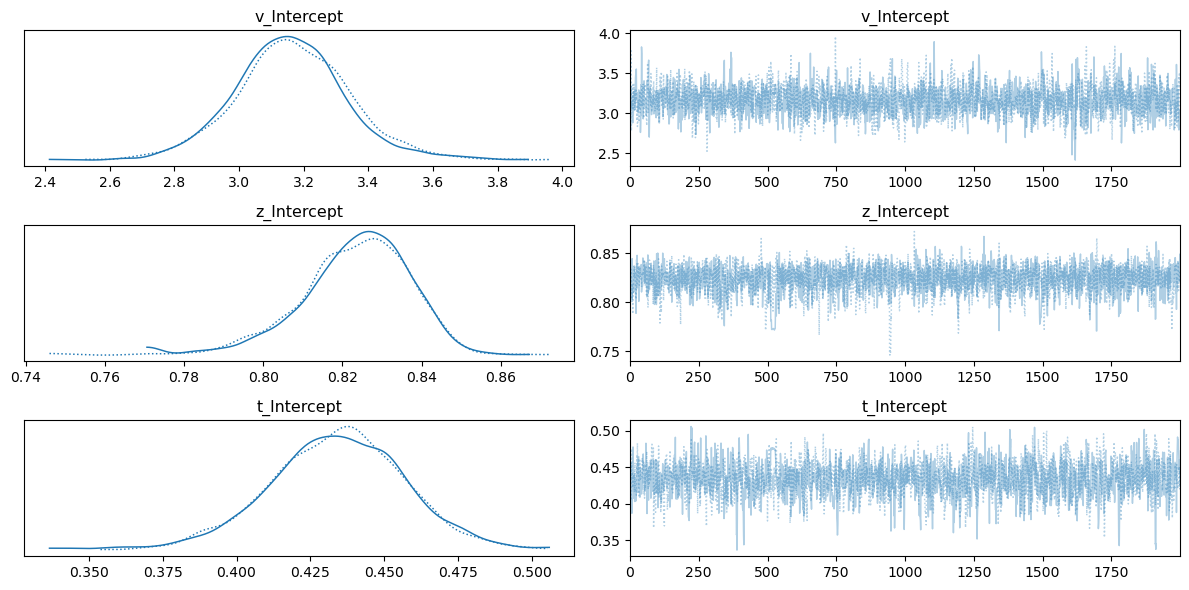

In [17]:
az.plot_trace(ddm_inferenceData,var_names=['v_Intercept','z_Intercept','t_Intercept'],divergences=None)
plt.tight_layout()

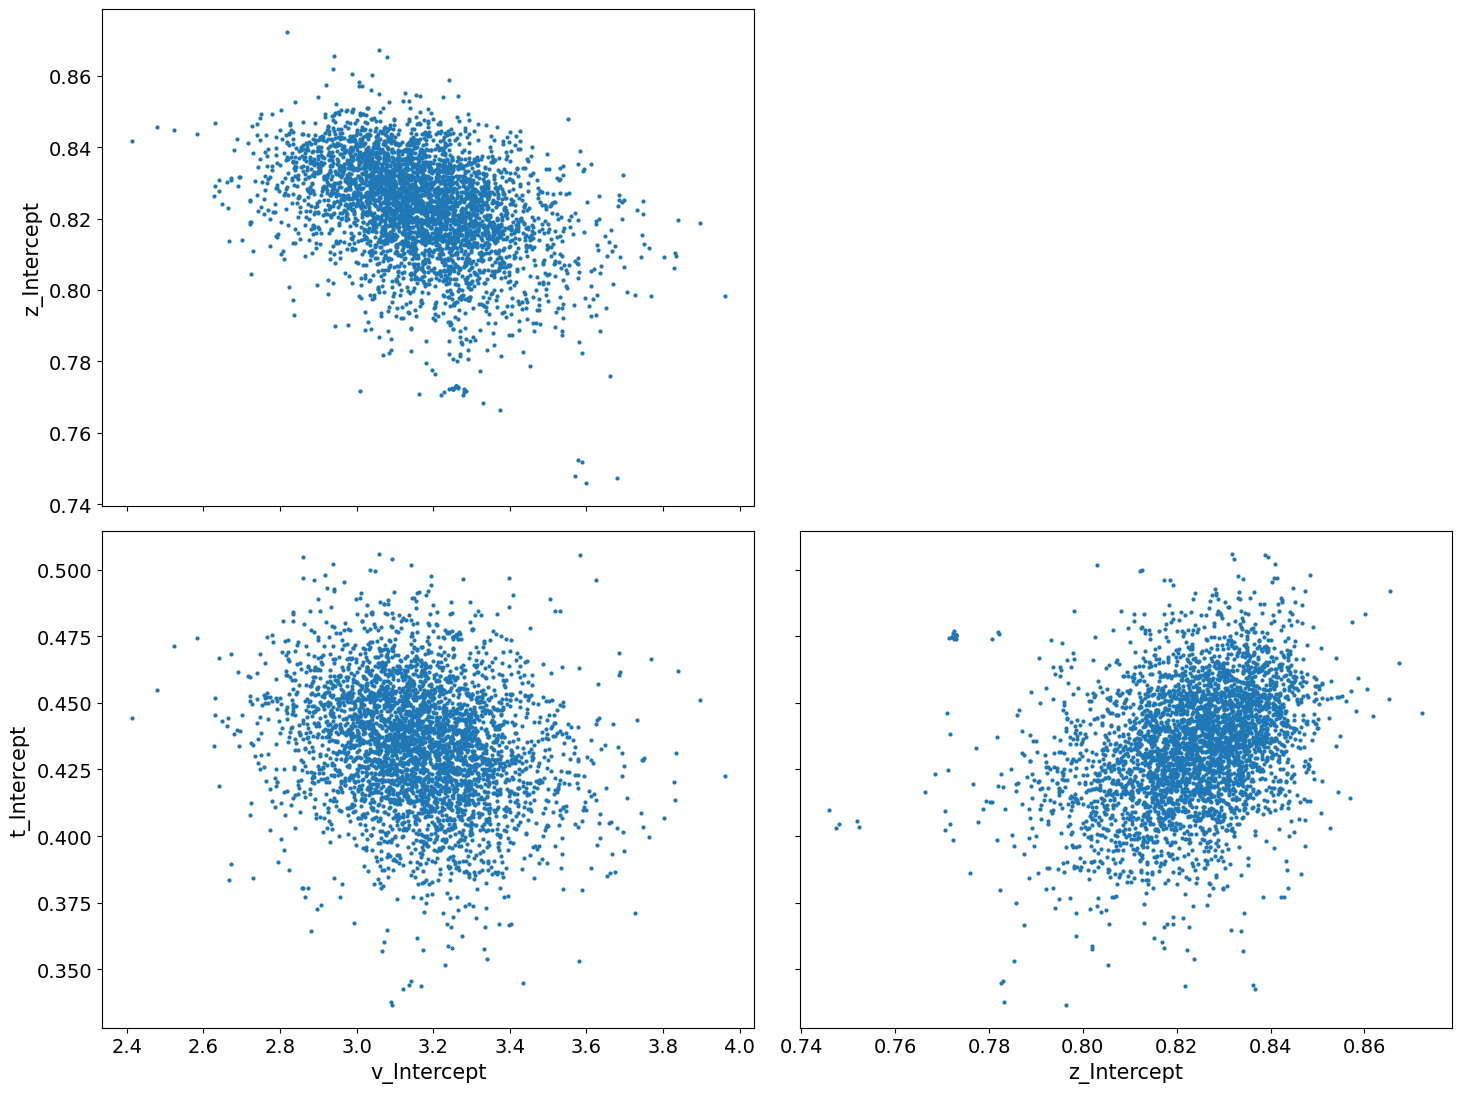

In [25]:
az.plot_pair(
    ddm_aFix_hier.traces,var_names=['v_Intercept','z_Intercept','t_Intercept']
)
plt.tight_layout()

In [26]:
fileName = basepath + '/models/ddm/sept24/numpyro/inferenceData_ddm_simple_allFree_noHier.nc'
ddm_inferenceData=az.from_netcdf(fileName)
ddm_inferenceData

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/users/afengler/data/software/miniconda3/envs/hssm_gpyou/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or n

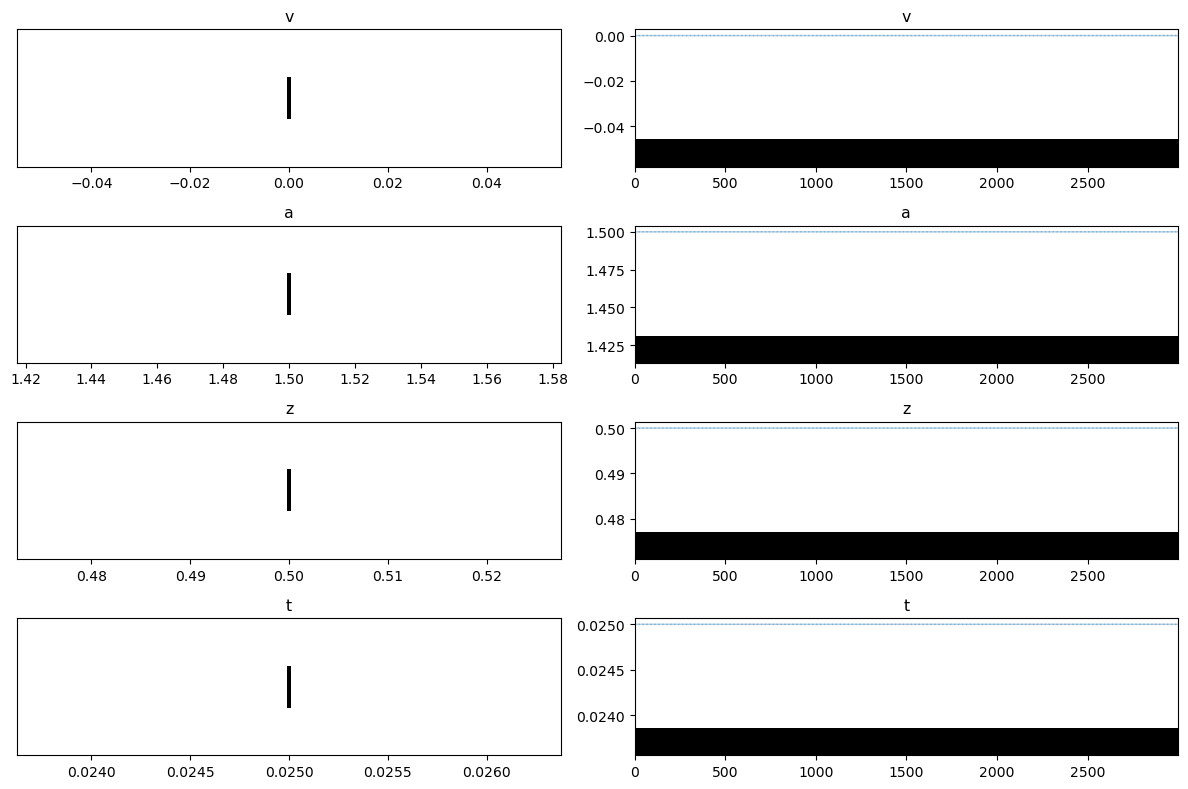

In [29]:
az.plot_trace(
    ddm_inferenceData,var_names=['v','a','z','t']
)
plt.tight_layout()

In [ ]:
az.plot_trace(
    ddm_inferenceData,var_names=['v','a','z','t']
)
plt.tight_layout()